# Milestone 1 - EDA and Preprocessing data 

***Important note*** - This is merely a template. you are more than free to change how it looks or create one from scratch.

- Load dataset
- Explore the dataset and ask atleast 5 questions to give you a better understanding of the data provided to you. 
- Visualise the answer to these 5 questions.
- Cleaning the data
    - Tidy up the column names, make sure there is no spaces
    - Observe,comment on and handle inconsistent data.(i.e duplicates, irrelevant data,incorrect data,etc)
    - Observe missing data and comment on why you believe it is missing(MCAR,MAR or MNAR).
    - Handle missing data
    - Observe and comment on outliers
    - Handle outliers
- With every change you are making to the data you need to comment on why you used this technique and how has it affected the data(by both showing the change in the data i.e change in number of rows/columns,change in distrubution, etc and commenting on it).
- Data transformation and feature engineering
    - Add 2 new columns named 'Week number' and 'Date range' and discretize the data into weeks according to the dates. 
        - Tip: Change the datatype of the date feature to datetime type instead of object.
    - Encode any categorical feature(s) and comment on why you used this technique and how the data has changed.
    - If exists , Identify feature(s) which need normalization and show your reasoning. Then choose a technique to normalize the feature(s) and comment on why you chose this technique.
- Additional data extraction
    - Add GPS coordinates for the cities/locations.
    - For this task you can extract the GPS coordinates from an API or web scraping and integrate into your csv file as new features. 
    - Tip 1 - you can find the web scraping and data integration notebooks under 'additional resources'  on the CMS useful.
    - Tip 2 - If you are going to use an API make sure you do not make request for each existing row but rather group by the cities and get their respective coordinates. Making a request for each row is too inefficient and expensive.
    - Tip 3 - Rather than running the code for calling the API each time you load the notebook, the first time you call the API save the results in a csv file and then you could you check if a csv file exists for the GPS coordinates, if so, load directly and don't call APi. Same applies for web scraping.

- Lookup table and load back into new csv file
    - Create a lookup table
    - Load the new dataset into a new csv file named `green_trip_data_{year}-{month}clean.csv`. replace year and month with the appropriate values.
    - Load the lookup table to a csv file called `lookup_table_green_taxis.csv` 
- Bonus: Load the dataset as a parquet file instead of a csv file(Parquet file is a compressed file format).

# 1 - Extraction

## Load necessary libraries

In [749]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import datetime
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
import math  
import pyarrow.parquet as pq

In [764]:
#Load the dataset
data_dir="datasets/"
nyc_df = pd.read_csv(data_dir+'green_tripdata_2019-03.csv')
nyc_df.head()

,Vendor,lpep pickup datetime,lpep dropoff datetime,store and fwd flag,Rate type,PU Location,DO Location,passenger count,trip distance,fare amount,extra,mta tax,tip amount,tolls amount,ehail fee,improvement surcharge,total amount,payment type,trip type,congestion surcharge
0,VeriFone Inc.,2019-03-01 00:02:21,2019-03-01 00:04:52,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,3.5,0.5,0.5,1.44,0.0,NaN,0.3,6.24,Credit card,Street-hail,0.0
1,VeriFone Inc.,2019-03-01 00:42:31,2019-03-01 00:47:42,N,Standard rate,"Brooklyn,East Williamsburg","Brooklyn,Williamsburg (South Side)",1.0,0.72,5.5,0.5,0.5,1.36,0.0,NaN,0.3,8.16,Credit card,Street-hail,0.0
2,"Creative Mobile Technologies, LLC",2019-03-01 00:15:53,2019-03-01 00:18:37,N,Standard rate,"Queens,Astoria","Queens,Old Astoria",1.0,0.50,4.0,0.5,0.5,0.00,0.0,NaN,0.3,5.30,Cash,Street-hail,0.0
3,VeriFone Inc.,2019-02-28 23:55:58,2019-03-01 00:01:30,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.19,6.0,0.5,0.5,1.46,0.0,NaN,0.3,8.76,Credit card,Street-hail,0.0
4,VeriFone Inc.,2019-03-01 00:55:58,2019-03-01 00:58:12,N,Standard rate,"Queens,Steinway","Queens,Steinway",1.0,0.55,4.0,0.5,0.5,0.00,0.0,NaN,0.3,5.30,Cash,Street-hail,0.0


In [751]:
# Resetting the index and creating a new 'trip_id' index starting from 1
nyc_df.reset_index(drop=True, inplace=True)
nyc_df.index = nyc_df.index + 1
nyc_df.index.name = 'trip_id'
nyc_df.head()

,Vendor,lpep pickup datetime,lpep dropoff datetime,store and fwd flag,Rate type,PU Location,DO Location,passenger count,trip distance,fare amount,extra,mta tax,tip amount,tolls amount,ehail fee,improvement surcharge,total amount,payment type,trip type,congestion surcharge
trip_id,,,,,,,,,,,,,,,,,,,,
1,VeriFone Inc.,2019-03-01 00:02:21,2019-03-01 00:04:52,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,3.5,0.5,0.5,1.44,0.0,NaN,0.3,6.24,Credit card,Street-hail,0.0
2,VeriFone Inc.,2019-03-01 00:42:31,2019-03-01 00:47:42,N,Standard rate,"Brooklyn,East Williamsburg","Brooklyn,Williamsburg (South Side)",1.0,0.72,5.5,0.5,0.5,1.36,0.0,NaN,0.3,8.16,Credit card,Street-hail,0.0
3,"Creative Mobile Technologies, LLC",2019-03-01 00:15:53,2019-03-01 00:18:37,N,Standard rate,"Queens,Astoria","Queens,Old Astoria",1.0,0.50,4.0,0.5,0.5,0.00,0.0,NaN,0.3,5.30,Cash,Street-hail,0.0
4,VeriFone Inc.,2019-02-28 23:55:58,2019-03-01 00:01:30,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.19,6.0,0.5,0.5,1.46,0.0,NaN,0.3,8.76,Credit card,Street-hail,0.0
5,VeriFone Inc.,2019-03-01 00:55:58,2019-03-01 00:58:12,N,Standard rate,"Queens,Steinway","Queens,Steinway",1.0,0.55,4.0,0.5,0.5,0.00,0.0,NaN,0.3,5.30,Cash,Street-hail,0.0


In [752]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643075 entries, 1 to 643075
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Vendor                 643075 non-null  object 
 1   lpep pickup datetime   643075 non-null  object 
 2   lpep dropoff datetime  643075 non-null  object 
 3   store and fwd flag     600511 non-null  object 
 4   Rate type              643075 non-null  object 
 5   PU Location            643075 non-null  object 
 6   DO Location            643075 non-null  object 
 7   passenger count        599382 non-null  float64
 8   trip distance          643075 non-null  float64
 9   fare amount            643075 non-null  float64
 10  extra                  296229 non-null  float64
 11  mta tax                643075 non-null  float64
 12  tip amount             643075 non-null  float64
 13  tolls amount           643075 non-null  float64
 14  ehail fee              269 non-null 

# 2- EDA

Q1: What is the shape of the dataset?

In [755]:
print(nyc_df.shape)

(643075, 20)


Q2:Which Features are the categorical features?

In [756]:
nyc_df.select_dtypes(include = "object").columns

Index(['Vendor', 'lpep pickup datetime', 'lpep dropoff datetime',
       'store and fwd flag', 'Rate type', 'PU Location', 'DO Location',
       'payment type', 'trip type'],
      dtype='object')

Q3:What are the numrical features?

In [757]:
nyc_df.select_dtypes(include=['int64','float'])

,passenger count,trip distance,fare amount,extra,mta tax,tip amount,tolls amount,ehail fee,improvement surcharge,total amount,congestion surcharge
trip_id,,,,,,,,,,,
1,1.0,0.00,3.5,0.5,0.5,1.44,0.0,NaN,0.3,6.24,0.0
2,1.0,0.72,5.5,0.5,0.5,1.36,0.0,NaN,0.3,8.16,0.0
3,1.0,0.50,4.0,0.5,0.5,0.00,0.0,NaN,0.3,5.30,0.0
4,1.0,1.19,6.0,0.5,0.5,1.46,0.0,NaN,0.3,8.76,0.0
5,1.0,0.55,4.0,0.5,0.5,0.00,0.0,NaN,0.3,5.30,0.0
...,...,...,...,...,...,...,...,...,...,...,...
643071,1.0,4.40,16.0,NaN,0.5,0.00,0.0,NaN,0.3,16.80,0.0
643072,1.0,1.11,6.0,NaN,0.5,0.00,0.0,NaN,0.3,6.80,0.0
643073,1.0,0.80,4.5,1.0,0.5,1.00,0.0,NaN,0.3,7.30,0.0


Q4:what are the number of the null and unique values of the categorial features ?

In [758]:
def explore_categorical_features(df):
    categorical_features = df.select_dtypes(include=['object', 'category'])
    for column in categorical_features.columns:
        null_count = df[column].isnull().sum()
        unique_count = df[column].nunique()
        value_counts = df[column].value_counts()
        
        print(f"Column: {column}")
        print(f"Number of Null Values: {null_count}")
        print(f"Number of Unique Values: {unique_count}")
        print("Value Counts:")
        print(value_counts)
        print("="*50)

In [10]:
explore_categorical_features(nyc_df)

Column: Vendor
Number of Null Values: 0
Number of Unique Values: 3
Value Counts:
Vendor
VeriFone Inc.                        553576
Creative Mobile Technologies, LLC     89498
Unknown                                   1
Name: count, dtype: int64
Column: lpep pickup datetime
Number of Null Values: 0
Number of Unique Values: 536819
Value Counts:
lpep pickup datetime
2019-03-13 10:59:00    13
2019-03-26 09:15:00    11
2019-03-07 09:02:00    10
2019-03-05 15:00:00    10
2019-03-05 12:00:00    10
                       ..
2019-03-12 14:49:18     1
2019-03-12 14:54:18     1
2019-03-12 14:30:20     1
2019-03-12 14:51:19     1
2019-04-01 00:01:51     1
Name: count, Length: 536819, dtype: int64
Column: lpep dropoff datetime
Number of Null Values: 0
Number of Unique Values: 536337
Value Counts:
lpep dropoff datetime
2019-03-10 00:00:00    33
2019-03-11 00:00:00    25
2019-03-31 00:00:00    25
2019-03-07 00:00:00    25
2019-03-04 00:00:00    23
                       ..
2019-03-12 13:47:25     1


what is the number of the null and unique values of the numerical features?

In [759]:
def explore_numerical_features(df):
    numerical_features = df.select_dtypes(include=['number'])
    results = {}
    for column in numerical_features.columns:
        null_count = df[column].isnull().sum()
        unique_count = df[column].nunique()
        value_counts = df[column].value_counts()
        mean_value = df[column].mean()
        std_dev = df[column].std()
        
        plt.figure(figsize=(8, 6))
        sns.kdeplot(df[column], shade=True)
        plt.xlabel(column)
        plt.ylabel('Density')
        plt.title(f'Distribution of {column}')
        plt.show()
        
        results[column] = {
            'null_count': null_count,
            'unique_count': unique_count,
            'value_counts': value_counts,
            'mean': mean_value,
            'std_dev': std_dev
        }
    return results

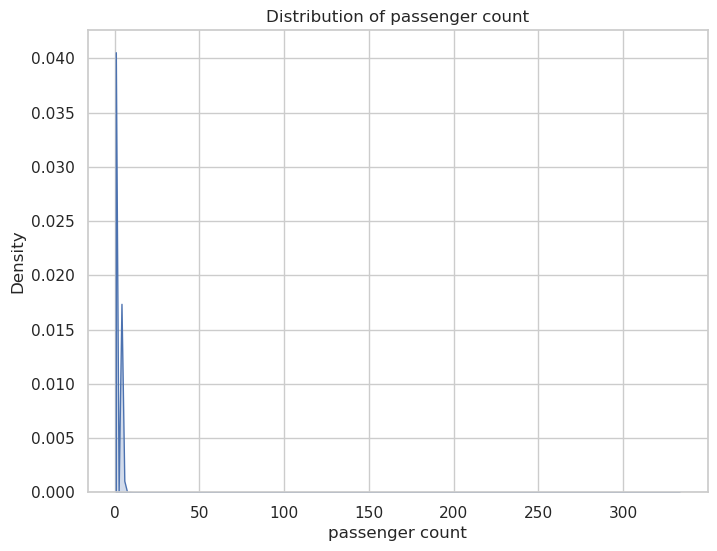

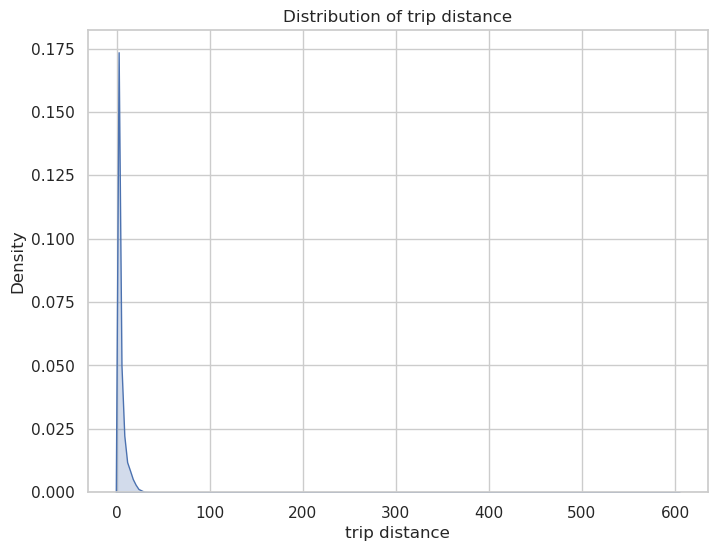

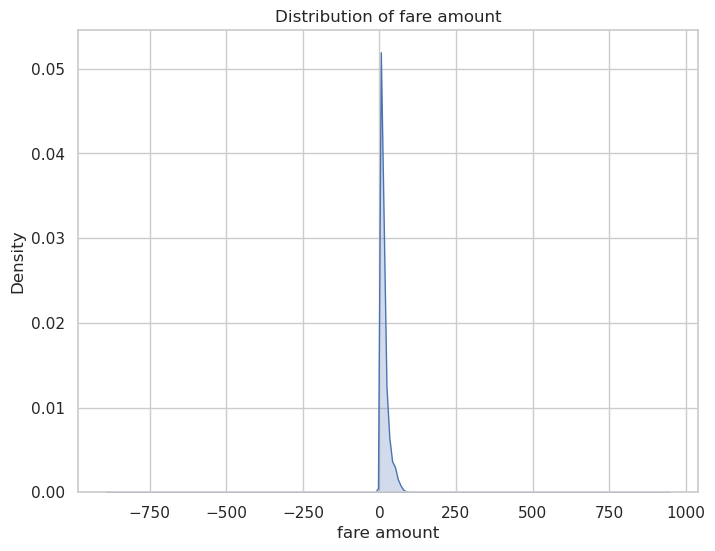

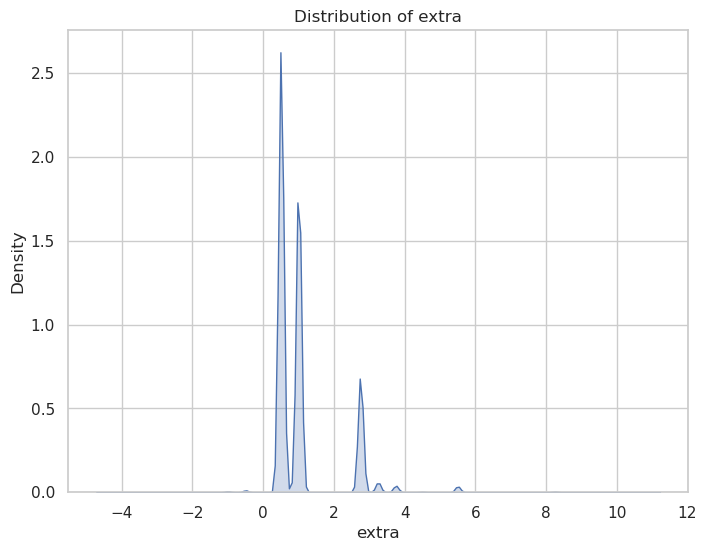

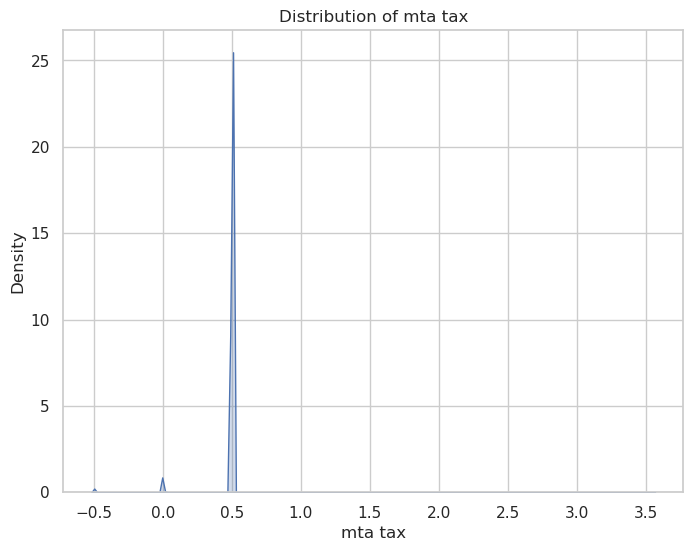

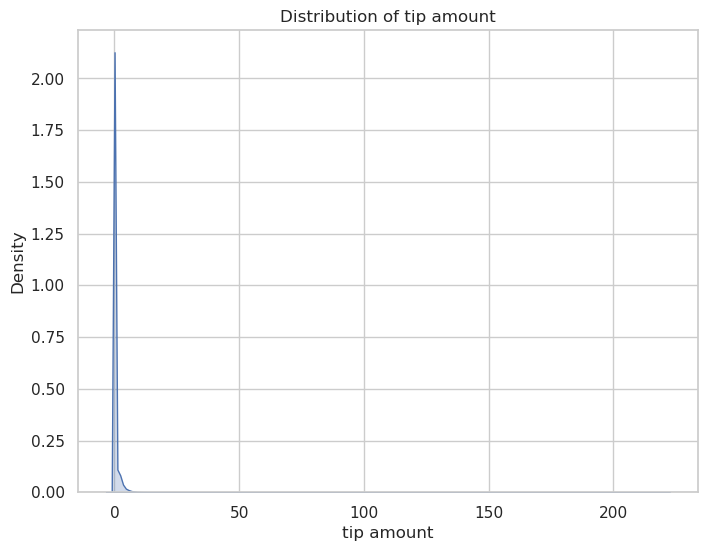

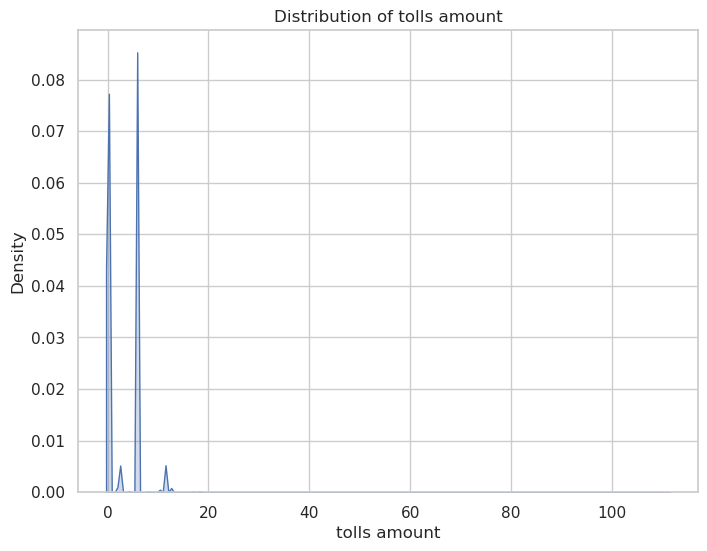

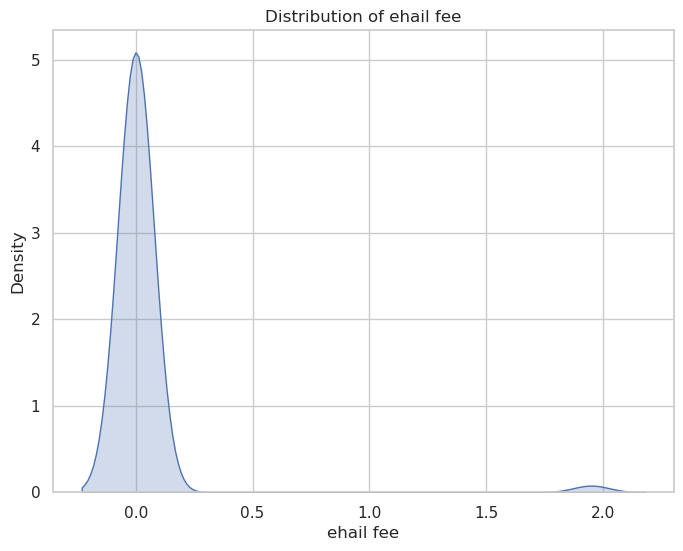

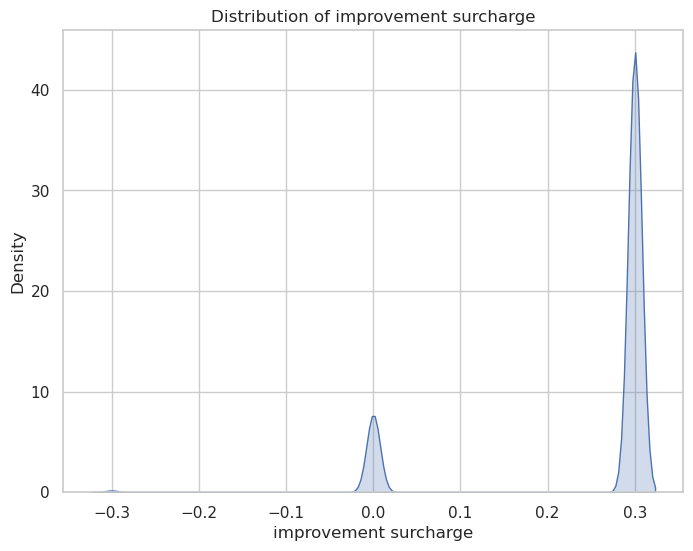

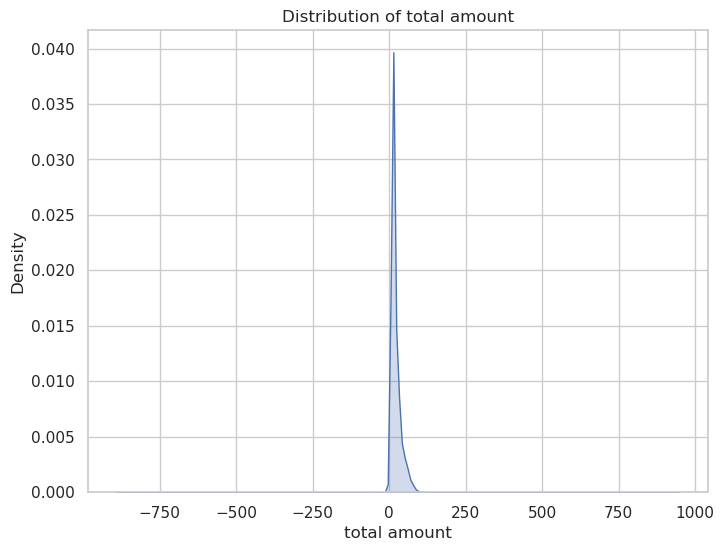

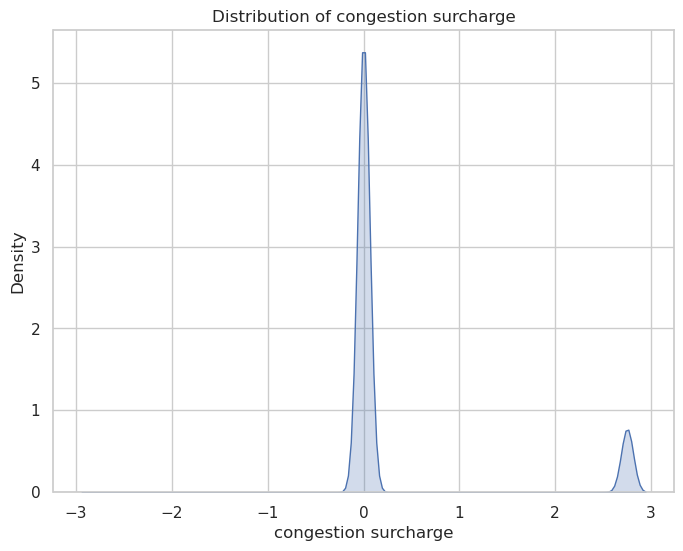

Column: passenger count
Number of Null Values: 43693
Number of Unique Values: 10
Value Counts:
passenger count
1.0      519209
2.0       43024
5.0       17551
6.0        8868
3.0        7713
4.0        2988
8.0          11
7.0           8
333.0         5
9.0           5
Name: count, dtype: int64
Mean: 1.31
Standard Deviation: 1.35
Column: trip distance
Number of Null Values: 0
Number of Unique Values: 3319
Value Counts:
trip distance
0.00     10627
0.80      5534
0.90      5533
1.00      5415
1.10      4996
         ...  
28.03        1
28.37        1
26.69        1
27.82        1
28.82        1
Name: count, Length: 3319, dtype: int64
Mean: 3.85
Standard Deviation: 4.49
Column: fare amount
Number of Null Values: 0
Number of Unique Values: 5896
Value Counts:
fare amount
 6.00     27652
 5.50     26294
 7.00     26033
 6.50     25860
 5.00     24745
          ...  
 58.24        1
 58.55        1
-21.50        1
 77.43        1
 79.13        1
Name: count, Length: 5896, dtype: int64
Mean

In [760]:
# Print the results for each numerical feature
numerical_results = explore_numerical_features(nyc_df)
for column, info in numerical_results.items():
    print(f"Column: {column}")
    print(f"Number of Null Values: {info['null_count']}")
    print(f"Number of Unique Values: {info['unique_count']}")
    print(f"Value Counts:\n{info['value_counts']}")
    print(f"Mean: {info['mean']:.2f}")
    print(f"Standard Deviation: {info['std_dev']:.2f}")
    print("="*50)

# Explore more features to build a good understanding of the dataset
1. Variation of the fare amount with day of the week

In [765]:
# Copy the original dataframe to a new one
nyc_df_to_deal=nyc_df.copy()

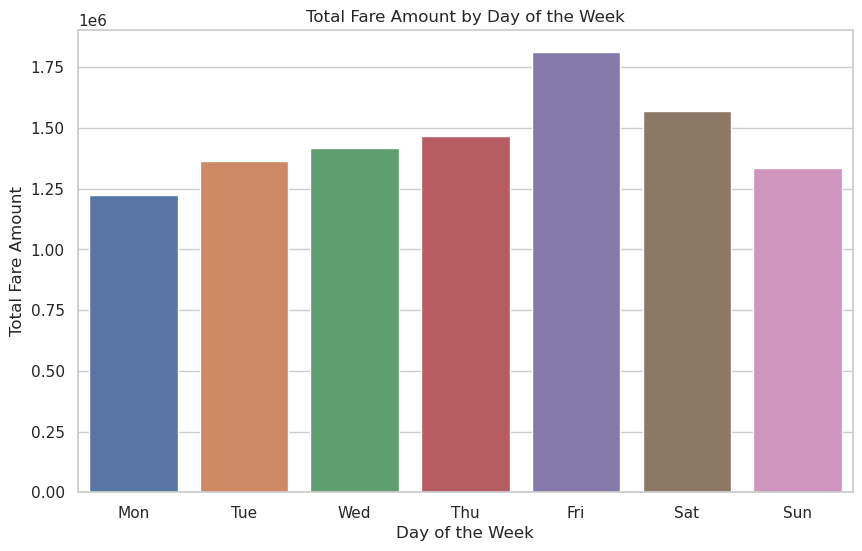

In [768]:
# Convert 'lpep pickup datetime' column to datetime format
nyc_df_to_deal['lpep pickup datetime'] = pd.to_datetime(nyc_df_to_deal['lpep pickup datetime'])

# Extract day of the week and create a new column
nyc_df_to_deal['pickup day'] = nyc_df_to_deal['lpep pickup datetime'].dt.dayofweek

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup day', y='fare amount', data=nyc_df_to_deal, estimator=sum, ci=None)
plt.xlabel('Day of the Week')
plt.ylabel('Total Fare Amount')
plt.title('Total Fare Amount by Day of the Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

2.Most common payment type 

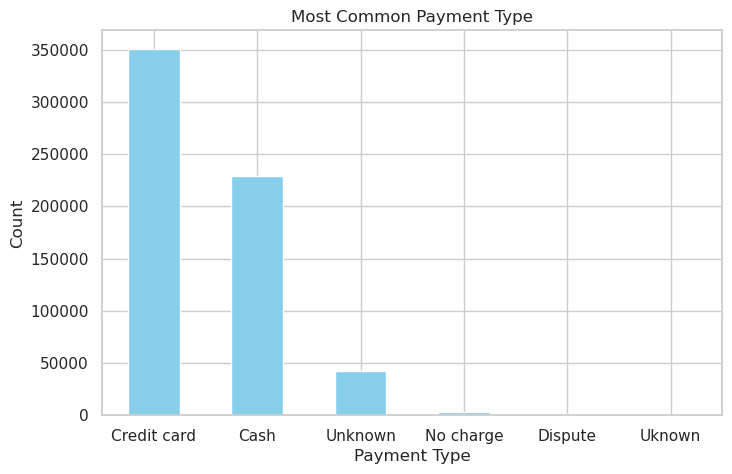

In [769]:
plt.figure(figsize=(8, 5))
nyc_df_to_deal['payment type'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.title('Most Common Payment Type')
plt.xticks(rotation=0)
plt.show()

3. Peak Hours for the green taxi trips

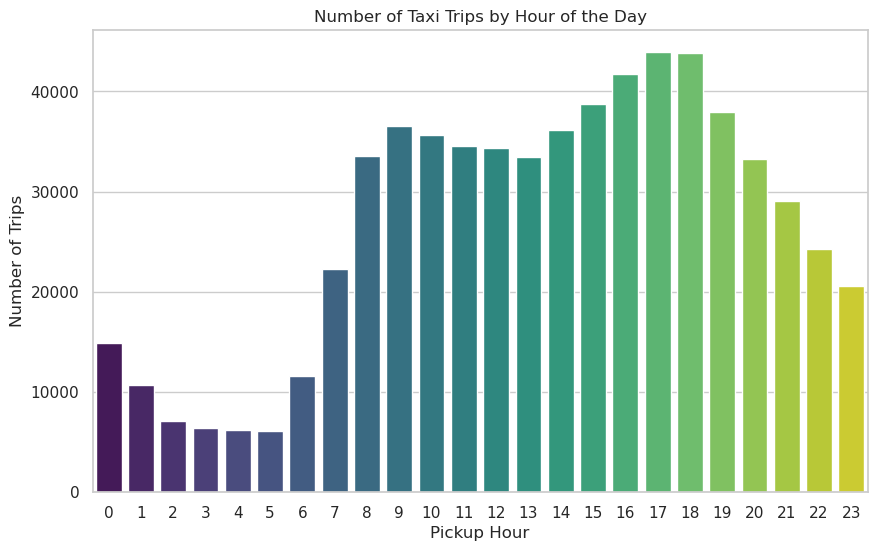

In [771]:
# Convert 'lpep pickup datetime' column to datetime format
nyc_df_to_deal['lpep pickup datetime'] = pd.to_datetime(nyc_df_to_deal['lpep pickup datetime'])

# Extract hour of the day and create a new column
nyc_df_to_deal['pickup hour'] = nyc_df_to_deal['lpep pickup datetime'].dt.hour

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(x='pickup hour', data=nyc_df_to_deal, palette='viridis')
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Trips')
plt.title('Number of Taxi Trips by Hour of the Day')
plt.show()


# 3 - Cleaning Data

## Tidying up column names

In [772]:
# A function to handle columns names

def rename_columns(df):
#     make all cols lower case
    df.columns = df.columns.str.lower()
    # Iterate through the column names and replace space with underscore,
#     using list comprehension
    df.columns = [col.replace(' ', '_') for col in df.columns]
    
#     equivalent,not using list comprehension
#     for col in df.columns:
#         col_no_spaces = col.replace('_', ' ')
#         df.rename(columns={col:col_no_spaces})

In [774]:
rename_columns(nyc_df_to_deal)
nyc_df_to_deal.columns

Index(['vendor', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'rate_type', 'pu_location', 'do_location',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'pickup_day', 'pickup_hour'],
      dtype='object')

## Observe inconsistent data

In [775]:
# get number of duplicates
print(nyc_df_to_deal.duplicated().sum())

28


In [776]:
#Remove duplicates to keep only unique rows.
nyc_df_to_deal.drop_duplicates(inplace=True)

['fare amount', 'extra', 'mta tax', 'tip amount', 'improvement surcharge', 'total amount', 'congestion surcharge']


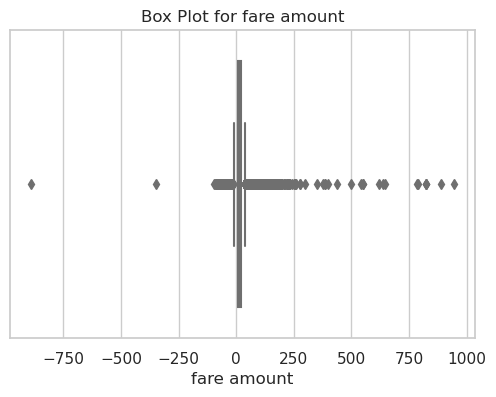

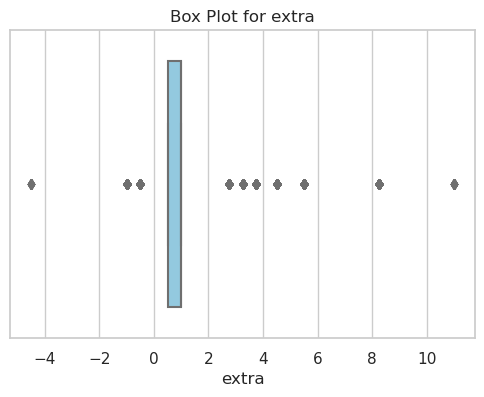

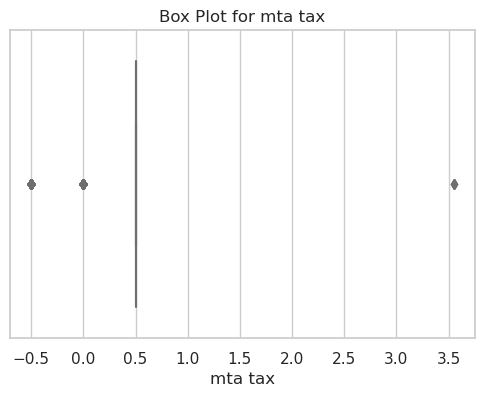

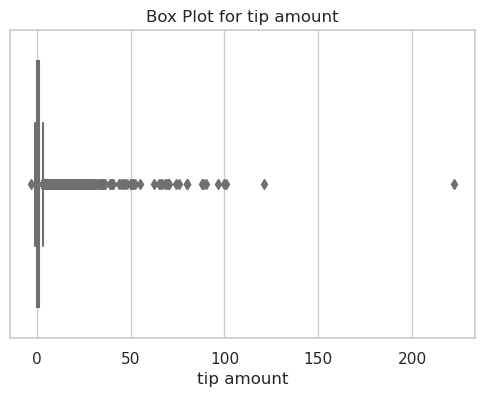

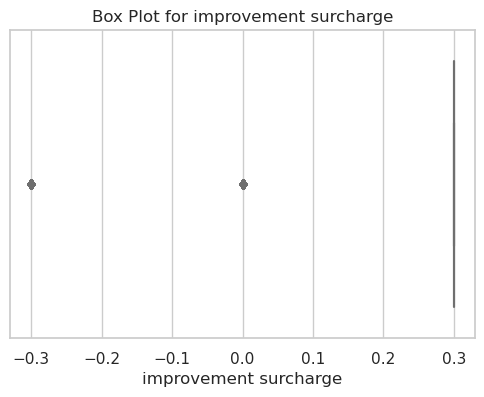

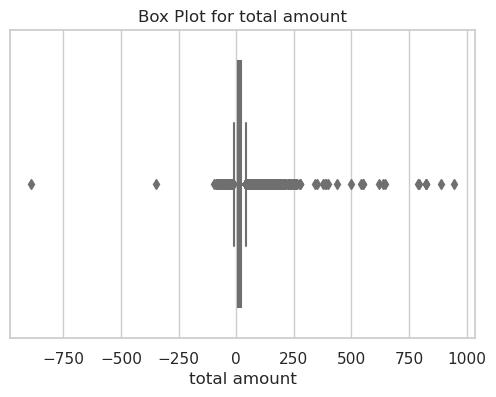

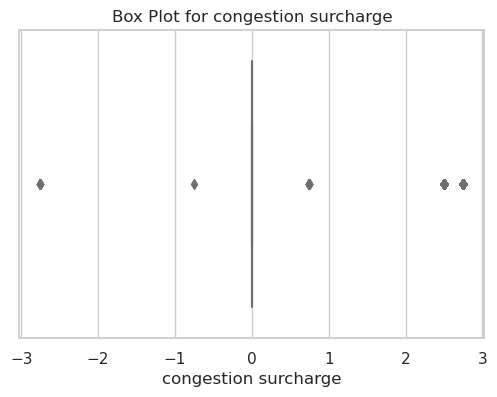

In [777]:
# Observe the numerical features that have negative values
numerical_features_df = nyc_df.select_dtypes(include=['number'])

# Identify numerical features with negative values
features_with_negative_values = (numerical_features_df < 0).any()
features_with_negative_values = features_with_negative_values[features_with_negative_values].index.tolist()
print(features_with_negative_values)
# Visualize numerical features with negative values using box plots
for feature in features_with_negative_values:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=feature, data=nyc_df, color='skyblue')
    plt.title(f'Box Plot for {feature}')
    plt.show()

In [780]:
# Columns with negative values
columns_with_negative_values = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']

# Count rows with negative values in any of the specified columns
rows_with_negative_values_count = len(nyc_df_to_deal[(nyc_df_to_deal[columns_with_negative_values] < 0).any(axis=1)])

# Total number of rows in the DataFrame
total_rows = len(nyc_df)

# Calculate the percentage of rows with negative values
percentage_of_rows_with_negative_values = (rows_with_negative_values_count / total_rows) * 100

print(f"Percentage of rows with negative values: {percentage_of_rows_with_negative_values:.2f}%")

Percentage of rows with negative values: 0.37%


In [781]:
# Calculate the mean for each specified column
mean_before_handling_negative_values = nyc_df_to_deal[columns_with_negative_values].mean()
# Print the means before handling negative values
print("Means before handling negative values:")
print(mean_before_handling_negative_values)

Means before handling negative values:
fare_amount              15.851971
extra                     1.059519
mta_tax                   0.487112
tip_amount                0.855418
improvement_surcharge     0.252975
total_amount             18.536555
congestion_surcharge      0.340814
dtype: float64


In [782]:
# Replace negative values in specified columns with absolute values
nyc_df_to_deal[columns_with_negative_values] = nyc_df_to_deal[columns_with_negative_values].apply(lambda x: abs(x))
mean_after_handling_negative_values = nyc_df_to_deal[columns_with_negative_values].mean()
# Print the means after handling negative values
print("Means after handling negative values:")
print(mean_after_handling_negative_values)

Means after handling negative values:
fare_amount              15.903488
extra                     1.064619
mta_tax                   0.490621
tip_amount                0.855472
improvement_surcharge     0.255048
total_amount             18.595585
congestion_surcharge      0.340880
dtype: float64


In [783]:
# Verify the changes of replacing the negative values with absolute
new_nonegative_rows_count = len(nyc_df_to_deal[(nyc_df_to_deal[columns_with_negative_values] < 0).any(axis=1)])
print(new_nonegative_rows_count)

0


In [784]:
# Replace incorrect value "333" in 'passenger_count' column with "3"
nyc_df_to_deal['passenger_count'] = nyc_df_to_deal['passenger_count'].replace(333, 3)

# Explanation for the replacement
# There seems to be an erroneous entry of "333" in the 'passenger_count' column. 
# Considering the context of the data and common taxi capacities, it is more likely that 
# this value was intended to be "3" but was recorded erroneously as "333". 
# Therefore, we have replaced it with the correct value "3" to ensure data accuracy.

In [785]:
# Replace 'Uknown' with 'Unknown' in the 'payment_type' column
nyc_df_to_deal['payment_type'] = nyc_df_to_deal['payment_type'].replace('Uknown', 'Unknown')

## Observing Missing Data

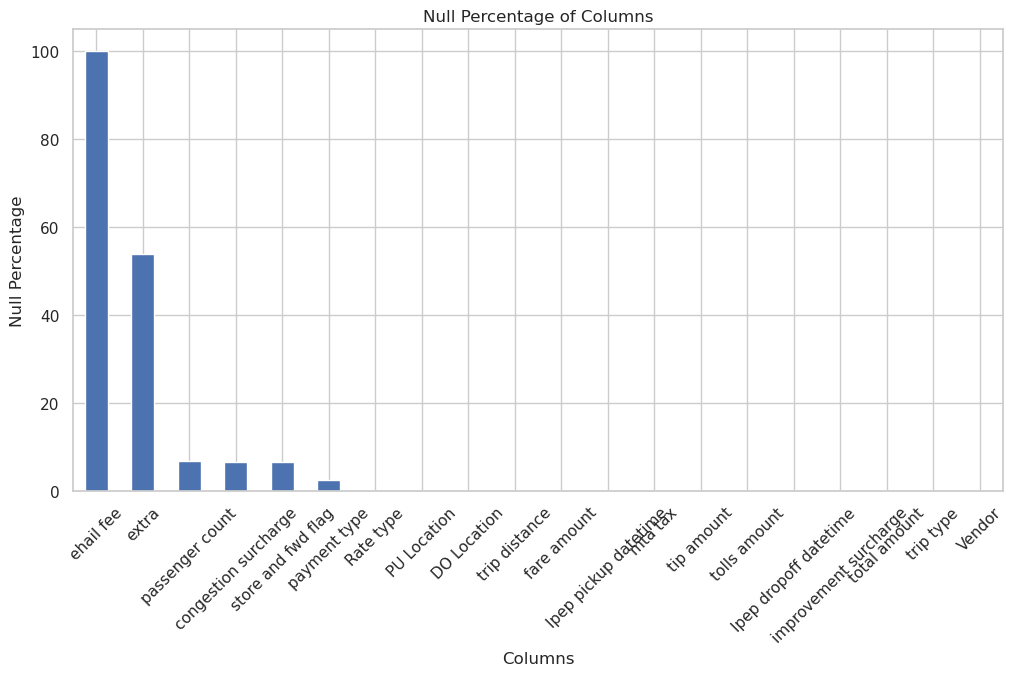

In [786]:
# Calculating sum of null entries and percentage of null entries
sum_null = nyc_df.isnull().sum()
perc_null = nyc_df.isnull().sum() / len(nyc_df)
perc_null_mean = nyc_df.isnull().mean()*100

# Sorting columns based on null percentages
perc_null_sorted = perc_null_mean.sort_values(ascending=False)

# Plotting the null percentages using a bar chart
plt.figure(figsize=(12, 6))
perc_null_sorted.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Null Percentage')
plt.title('Null Percentage of Columns')
plt.xticks(rotation=45)
plt.show()

In [787]:
# Get percentage of missing of each column 
print(perc_null_mean)

# Filter columns with missing data percentage >= 10% 
columns_with_high_missing_percentage = perc_null_mean[perc_null_mean >= 10].index.tolist()

# Print the column names
print("Columns with missing data percentage >= 10%:")
print(columns_with_high_missing_percentage)

Vendor                    0.000000
lpep pickup datetime      0.000000
lpep dropoff datetime     0.000000
store and fwd flag        6.618824
Rate type                 0.000000
PU Location               0.000000
DO Location               0.000000
passenger count           6.794386
trip distance             0.000000
fare amount               0.000000
extra                    53.935544
mta tax                   0.000000
tip amount                0.000000
tolls amount              0.000000
ehail fee                99.958170
improvement surcharge     0.000000
total amount              0.000000
payment type              2.567041
trip type                 0.000000
congestion surcharge      6.618824
dtype: float64
Columns with missing data percentage >= 10%:
['extra', 'ehail fee']


## Handling Missing data

In [788]:
# rcopy the original to a new dataframe for handling missing data
nyc_df_clean = nyc_df_to_deal.copy()
nyc_df_clean.head()

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,pickup_day,pickup_hour
0,VeriFone Inc.,2019-03-01 00:02:21,2019-03-01 00:04:52,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,3.5,...,1.44,0.0,NaN,0.3,6.24,Credit card,Street-hail,0.0,4,0
1,VeriFone Inc.,2019-03-01 00:42:31,2019-03-01 00:47:42,N,Standard rate,"Brooklyn,East Williamsburg","Brooklyn,Williamsburg (South Side)",1.0,0.72,5.5,...,1.36,0.0,NaN,0.3,8.16,Credit card,Street-hail,0.0,4,0
2,"Creative Mobile Technologies, LLC",2019-03-01 00:15:53,2019-03-01 00:18:37,N,Standard rate,"Queens,Astoria","Queens,Old Astoria",1.0,0.50,4.0,...,0.00,0.0,NaN,0.3,5.30,Cash,Street-hail,0.0,4,0
3,VeriFone Inc.,2019-02-28 23:55:58,2019-03-01 00:01:30,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.19,6.0,...,1.46,0.0,NaN,0.3,8.76,Credit card,Street-hail,0.0,3,23
4,VeriFone Inc.,2019-03-01 00:55:58,2019-03-01 00:58:12,N,Standard rate,"Queens,Steinway","Queens,Steinway",1.0,0.55,4.0,...,0.00,0.0,NaN,0.3,5.30,Cash,Street-hail,0.0,4,0


In [789]:
#drop the ehail fee column as it may not provide meaningful information for analysis.
nyc_df_clean.drop(columns=['ehail_fee'], inplace=True)

In [790]:
# Define the function to detect the relation between missing data
def detect_missing_relation(featuresA, featuresB, df):
    # Iterate over each feature in features A (Missing Features)
    for featureA in featuresA:
        print("Detect missing of Feature: " +featureA)
        # Iterate over each feature in features B (ALL Features)
        for featureB in featuresB:
            if featureA != featureB:
                # Calculate statistics between featureA and featureB
                statistics_between_fetA_and_fetB = df[featureA].isnull().groupby(df[featureB]).mean().sort_values(ascending=False) * 100
                
                # Print statistics
                print(statistics_between_fetA_and_fetB)
                '''
                # Visualize the relationship using a bar plot
                sns.set(rc={'figure.figsize': (15, 10)})
                plt.xticks(rotation=90)
                sns.barplot(x=statistics_between_fetA_and_fetB.keys()[:min(40, len(statistics_between_fetA_and_fetB))].tolist(),
                            y=statistics_between_fetA_and_fetB.values[:min(40, len(statistics_between_fetA_and_fetB))].tolist()) \
                .set_title(f"Relation between missing values in {featureA} and {featureB}")
                
                # Set labels
                plt.ylabel('Percentage of Missing Data')
                plt.show()
                '''

In [223]:
featuresA = ['payment_type']  # List of features with missing values

# Call the function to detect the relation between numerical features with missing values and all other features
detect_missing_relation(featuresA, nyc_df_clean.columns.drop(featuresA), nyc_df_clean)

Detect missing of Feature: payment_type
vendor
Creative Mobile Technologies, LLC    18.445105
Unknown                               0.000000
VeriFone Inc.                         0.000000
Name: payment_type, dtype: float64
lpep_pickup_datetime
2019-03-12 21:33:33    100.0
2019-03-04 18:12:17    100.0
2019-03-04 18:09:29    100.0
2019-03-31 11:50:59    100.0
2019-03-19 21:10:28    100.0
                       ...  
2019-03-11 13:48:37      0.0
2019-03-11 13:48:33      0.0
2019-03-11 13:48:32      0.0
2019-03-11 13:48:20      0.0
2019-06-15 04:53:04      0.0
Name: payment_type, Length: 536819, dtype: float64
lpep_dropoff_datetime
2019-03-17 15:54:31    100.0
2019-03-13 15:27:57    100.0
2019-03-02 01:37:18    100.0
2019-03-06 10:22:17    100.0
2019-03-27 05:22:05    100.0
                       ...  
2019-03-11 13:45:56      0.0
2019-03-11 13:45:52      0.0
2019-03-11 13:45:50      0.0
2019-03-11 13:45:47      0.0
2019-06-15 12:05:04      0.0
Name: payment_type, Length: 536337, dtype: fl

## based on the analysis Of missing values of Payment type
the missing values in the 'payment_type' column appear to be Missing at Random (MAR). This means that the missingness of payment types does not seem to depend on the specific values in the 'payment_type' column itself, but rather it might be related to other columns in the dataset.

In [791]:
# A function to fill the null values with mode for the categorial features
def fill_null_with_mode(df, column):

    # calculate the mode value

    mode_value = df[column].mode()[0]

    # replace null values with the mode value

    df[column].fillna(mode_value, inplace=True)

    return df

In [792]:
# A function to fill the null values with mean for the numerical features
def fill_null_with_mean(df, column_name):
    df_filled = df.copy() # Create a copy of the original DataFrame
    
    if column_name in df_filled.columns and df_filled[column_name].isnull().any():
        mean_value = df_filled[column_name].mean() # Calculate the mean of the specified column
        df_filled[column_name].fillna(mean_value, inplace=True) # Fill null values with mean
    
    return df_filled

In [793]:
# After analyzing these percentages , missing values of payment_type and total_Amount is MAR , so we use mode imputation
fill_null_with_mode(nyc_df_clean,'payment_type')
# check
nyc_df_clean.isnull().sum()['payment_type']

0

In [794]:
# And for "store and fwd flag" is MCAR, so we use mode imputation

fill_null_with_mode(nyc_df_clean,'store_and_fwd_flag')
# check
nyc_df_clean.isnull().sum()['store_and_fwd_flag']

0

## Regarding missing values of passenger count
A driver may forget to enter the passenger count or enters it incorrectly), then it's reasonable to assume that the missing values are Missing at Random (MAR). In this case, the missingness is likely unrelated to any observed or unobserved variables in your dataset and occurs randomly.
- So ,we will use mean imputation

In [795]:
# Calculate the mean of non-missing values in the 'passenger_count' column
mean_passenger_count = nyc_df_clean['passenger_count'].mean()

# Impute missing values with the mean
nyc_df_clean['passenger_count'].fillna(mean_passenger_count, inplace=True)

# Verify that there are no more missing values in 'passenger_count'
#print("Number of missing values in 'passenger_count':", nyc_df_clean['passenger_count'].isnull().sum())


#fill_null_with_mean(nyc_df_clean,'passenger_count')
# check
nyc_df_clean.isnull().sum()['passenger_count']


0

In [796]:
# Create a new binary feature indicating whether the trip occurred before or after the introduction of the congestion surcharge
nyc_df_clean['surcharge_introduced'] = nyc_df_clean['lpep_pickup_datetime'] >= '2019-01-01'

# Analyze missing values in 'congestion surcharge' column with respect to the new feature and other relevant variables
surcharge_related_cols = ['surcharge_introduced', 'pu_location', 'do_location', 'trip_distance', 'total_amount']

for col in surcharge_related_cols:
    print(f"Missing values analysis for '{col}' with respect to 'congestion surcharge':")
    print(nyc_df_clean.groupby(nyc_df_clean['congestion_surcharge'].isnull())[col].value_counts(normalize=True))
    print("\n" + "="*50 + "\n")


Missing values analysis for 'surcharge_introduced' with respect to 'congestion surcharge':
congestion_surcharge  surcharge_introduced
False                 True                    0.999982
                      False                   0.000018
True                  True                    1.000000
Name: proportion, dtype: float64


Missing values analysis for 'pu_location' with respect to 'congestion surcharge':
congestion_surcharge  pu_location                           
False                 Manhattan,East Harlem North               0.070037
                      Manhattan,East Harlem South               0.058661
                      Manhattan,Central Harlem                  0.056768
                      Queens,Astoria                            0.039858
                      Queens,Elmhurst                           0.039720
                                                                  ...   
True                  Manhattan,Alphabet City                   0.000023
            

## Missing Values of congestion surcharge
- it seems that the missing values in the 'congestion surcharge' column are not directly related to any of the analyzed features. It might be a good idea to fill the missing values in the 'congestion surcharge' column
- One common approach could be to fill the missing values with the surcharge amount (2.75) since the surcharge was introduced uniformly for green taxis passing through the congestion zone.

In [798]:
nyc_df_clean['congestion_surcharge'].fillna(2.75, inplace=True)

In [799]:
# Verify that there are no more missing values in 'congestion_surcharge'
print("Number of missing values in 'congestion_surcharge':", nyc_df_clean['congestion_surcharge'].isnull().sum())

Number of missing values in 'congestion_surcharge': 0


In [800]:
# Handle the extra feature
# Create a new binary feature indicating rush hours or overnight trips
nyc_df_clean['rush_hour_overnight'] = ((nyc_df_clean['lpep_pickup_datetime'].dt.hour >= 16) | 
                                       (nyc_df_clean['lpep_pickup_datetime'].dt.hour <= 6)).astype(int)
# Analyze missing values in 'extra' column with respect to the new feature and other relevant variables
extra_related_cols = ['rush_hour_overnight']

for col in extra_related_cols:
    print(f"Missing values analysis for '{col}' with respect to 'extra':")
    print(nyc_df_clean.groupby(nyc_df_clean['extra'].isnull())[col].value_counts(normalize=True))
    print("\n" + "="*50 + "\n")

Missing values analysis for 'rush_hour_overnight' with respect to 'extra':
extra  rush_hour_overnight
False  1                      0.896350
       0                      0.103650
True   0                      0.791938
       1                      0.208062
Name: proportion, dtype: float64




## Missing Values of extra 
- There seems to be a correlation between missing 'extra' values and trips not occurring during rush hours or overnight. It might be reasonable to fill missing 'extra' values with 0, indicating no extra charge for non-rush hour trips.
- Fill missing 'extra' values with 0 for trips not during rush hours or overnight

In [801]:
nyc_df_clean['extra'].fillna(0, inplace=True)
# Verify that there are no more missing values in 'extra'
print("Number of missing values in 'extra':", nyc_df_clean['extra'].isnull().sum())

Number of missing values in 'extra': 0


In [802]:
# Create a new column 'is_total_amount_valid' to check if 'total_amount' is the sum of specified columns
columns_to_sum = ['fare_amount', 'mta_tax', 'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge','congestion_surcharge']
nyc_df_clean['is_total_amount_valid'] = nyc_df_clean['total_amount'] == nyc_df_clean[columns_to_sum].sum(axis=1)

# Count the number of False values in the 'is_total_amount_valid' column
false_count = nyc_df_clean['is_total_amount_valid'].value_counts().get(False, 0)

# Print the number of False values
print(f"Number of False values in 'is_total_amount_valid' column: {false_count}")


Number of False values in 'is_total_amount_valid' column: 107741


In [803]:
# Calculate the difference between 'total_amount' and the sum of other columns excluding 'extra'
extra_difference = nyc_df_clean['total_amount'] - (nyc_df_clean['fare_amount'] +
                                                   nyc_df_clean['mta_tax'] +
                                                   nyc_df_clean['tip_amount'] +
                                                   nyc_df_clean['tolls_amount'] +
                                                   nyc_df_clean['improvement_surcharge']+
                                                   nyc_df_clean['congestion_surcharge'])

# Replace 'extra' values in rows where 'is_total_amount_valid' is False with the calculated difference
nyc_df_clean.loc[~nyc_df_clean['is_total_amount_valid'], 'extra'] = extra_difference

# Double-check by verifying if 'total_amount' matches the sum of columns including the modified 'extra'
nyc_df_clean['is_total_amount_valid_check'] = nyc_df_clean['total_amount'] == \
                                               (nyc_df_clean['fare_amount'] +
                                                nyc_df_clean['mta_tax'] +
                                                nyc_df_clean['tip_amount'] +
                                                nyc_df_clean['tolls_amount'] +
                                                nyc_df_clean['improvement_surcharge'] +
                                                nyc_df_clean['congestion_surcharge'] +
                                                nyc_df_clean['extra'])

# Print the number of False values in the 'is_total_amount_valid_check' column
print("Number of False values in 'is_total_amount_valid_check' column:", 
      len(nyc_df_clean[~nyc_df_clean['is_total_amount_valid_check']]))

Number of False values in 'is_total_amount_valid_check' column: 1313


In [804]:
# Define a threshold for validation (e.g., 0.01)
threshold = 0.01

# Calculate the extra value based on other columns
calculated_extra = nyc_df_clean['total_amount'] - (nyc_df_clean['fare_amount'] + nyc_df_clean['mta_tax'] +
                                                   nyc_df_clean['tip_amount'] + nyc_df_clean['tolls_amount'] +
                                                   nyc_df_clean['improvement_surcharge']+
                                                   nyc_df_clean['congestion_surcharge'])

# Check if the absolute difference is within the threshold
nyc_df_clean['is_total_amount_valid_check'] = abs(calculated_extra - nyc_df_clean['extra']) < threshold
print("Number of False values in 'is_total_amount_valid_check' column:", 
      len(nyc_df_clean[~nyc_df_clean['is_total_amount_valid_check']]))

Number of False values in 'is_total_amount_valid_check' column: 0


In [805]:
# Round 'extra' column to one decimal place
nyc_df_clean['extra'] = nyc_df_clean['extra'].round(1)
extra_value_counts = nyc_df_clean['extra'].value_counts()

In [806]:
# Calculate the mean of positive 'extra' values
mean_extra = nyc_df_clean[nyc_df_clean['extra'] >= 0]['extra'].mean()

# Replace negative 'extra' values with the mean
nyc_df_clean['extra'] = nyc_df_clean['extra'].apply(lambda x: mean_extra if x < 0 else x)

# Round 'extra' column to one decimal place
nyc_df_clean['extra'] = nyc_df_clean['extra'].round(1)

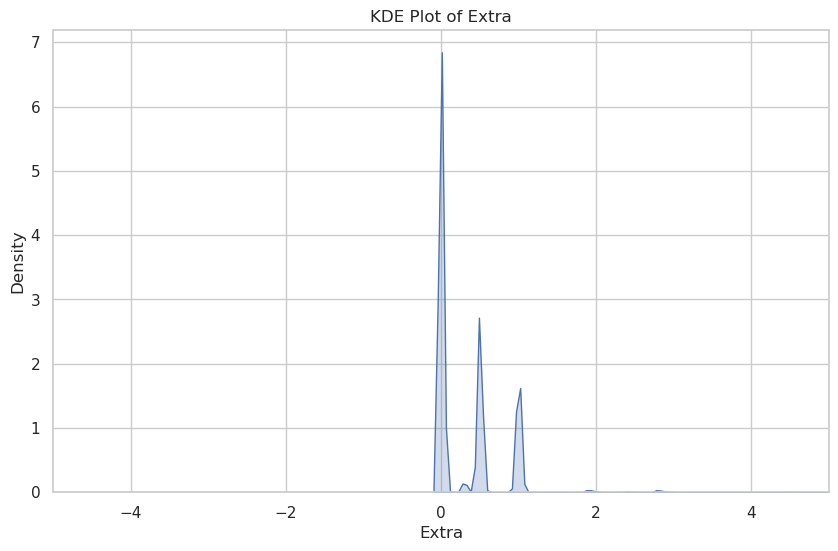

In [807]:
# Plotting extra column after handling missing and incorrect data

# Set style
sns.set(style="whitegrid")
# Create KDE plot for 'extra' column
plt.figure(figsize=(10, 6))
sns.kdeplot(nyc_df_clean['extra'], shade=True)
plt.xlabel('Extra')
plt.ylabel('Density')
plt.title('KDE Plot of Extra')
plt.xlim(-5,5)  # Set x-axis range
plt.show()

In [808]:
# A function to explore each numerical feature after dropping missing values
def explore_numerical_features_after_clean(dataframe):
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64'])
    
    for column in numerical_features.columns:
        print(f"Exploring feature: {column}")
        print(f"Number of Null Values: {numerical_features[column].isnull().sum()}")
        print(f"Number of Unique Values: {numerical_features[column].nunique()}")
        print(f"Statistics: {numerical_features[column].describe()}\n")
        
        # Visualization: KDE Plot and Boxplot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.kdeplot(dataframe[column].dropna(), shade=True)
        plt.title(f'KDE Plot of {column}')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=dataframe[column].dropna())
        plt.title(f'Boxplot of {column}')
        
        plt.tight_layout()
        plt.show()

Exploring feature: passenger_count
Number of Null Values: 0
Number of Unique Values: 10
Statistics: count    643047.000000
mean          1.303882
std           0.924073
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: passenger_count, dtype: float64



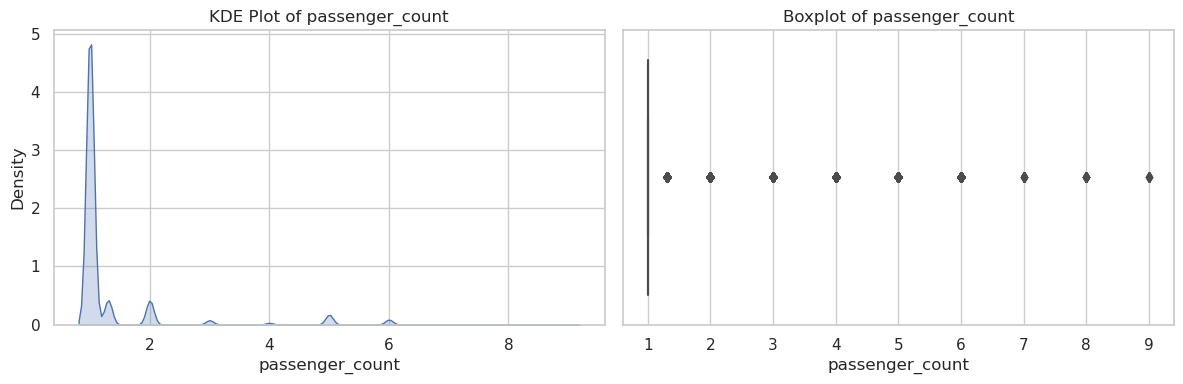

Exploring feature: trip_distance
Number of Null Values: 0
Number of Unique Values: 3319
Statistics: count    643047.000000
mean          3.852445
std           4.486270
min           0.000000
25%           1.110000
50%           2.180000
75%           4.770000
max         603.800000
Name: trip_distance, dtype: float64



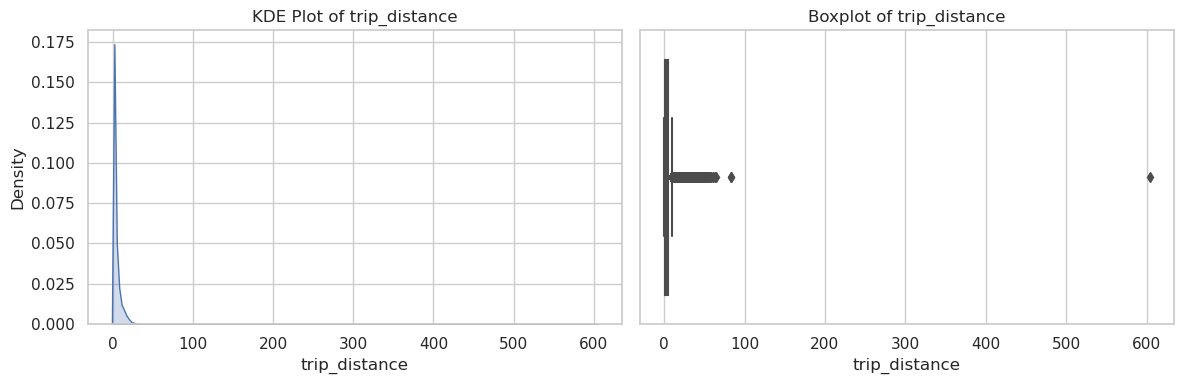

Exploring feature: fare_amount
Number of Null Values: 0
Number of Unique Values: 5807
Statistics: count    643047.000000
mean         15.903488
std          14.415826
min           0.000000
25%           7.000000
50%          11.000000
75%          19.500000
max         944.980000
Name: fare_amount, dtype: float64



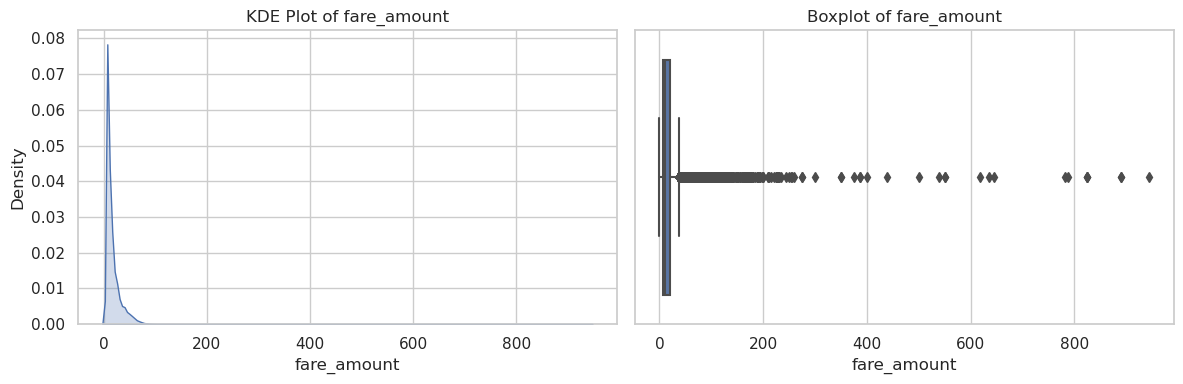

Exploring feature: extra
Number of Null Values: 0
Number of Unique Values: 31
Statistics: count    643047.000000
mean          0.315478
std           0.464512
min           0.000000
25%           0.000000
50%           0.000000
75%           0.500000
max          10.400000
Name: extra, dtype: float64



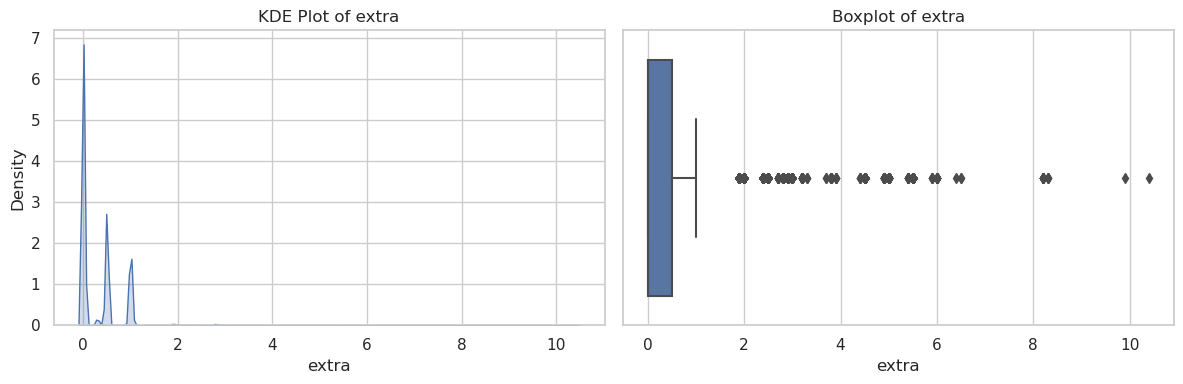

Exploring feature: mta_tax
Number of Null Values: 0
Number of Unique Values: 3
Statistics: count    643047.000000
mean          0.490621
std           0.068207
min           0.000000
25%           0.500000
50%           0.500000
75%           0.500000
max           3.550000
Name: mta_tax, dtype: float64



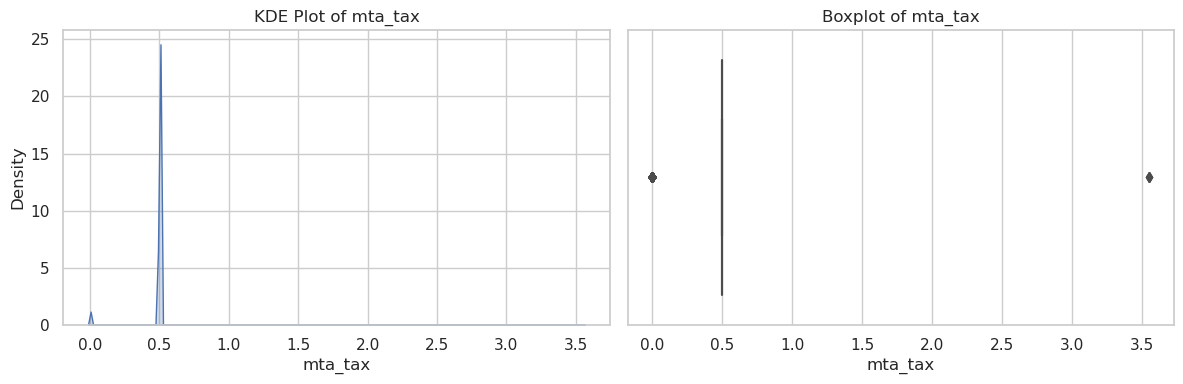

Exploring feature: tip_amount
Number of Null Values: 0
Number of Unique Values: 1477
Statistics: count    643047.000000
mean          0.855472
std           1.807673
min           0.000000
25%           0.000000
50%           0.000000
75%           1.360000
max         222.220000
Name: tip_amount, dtype: float64



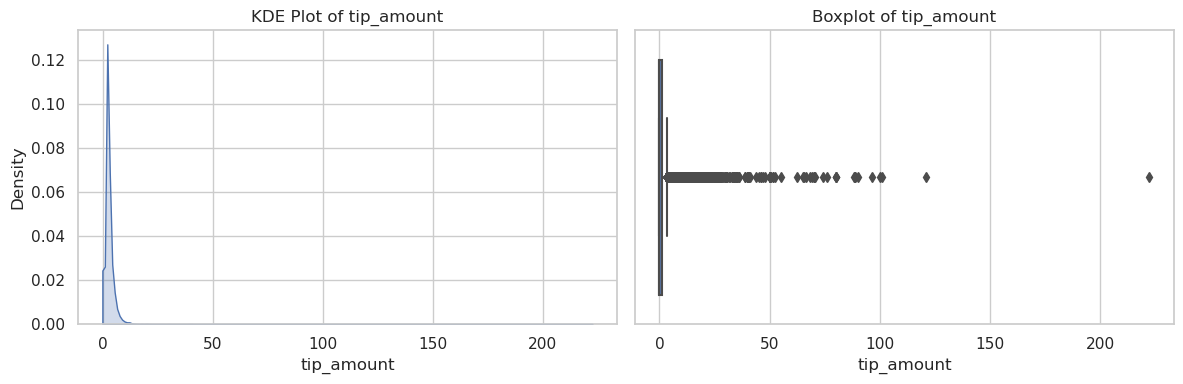

Exploring feature: tolls_amount
Number of Null Values: 0
Number of Unique Values: 114
Statistics: count    643047.000000
mean          0.319188
std           1.404061
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         111.110000
Name: tolls_amount, dtype: float64



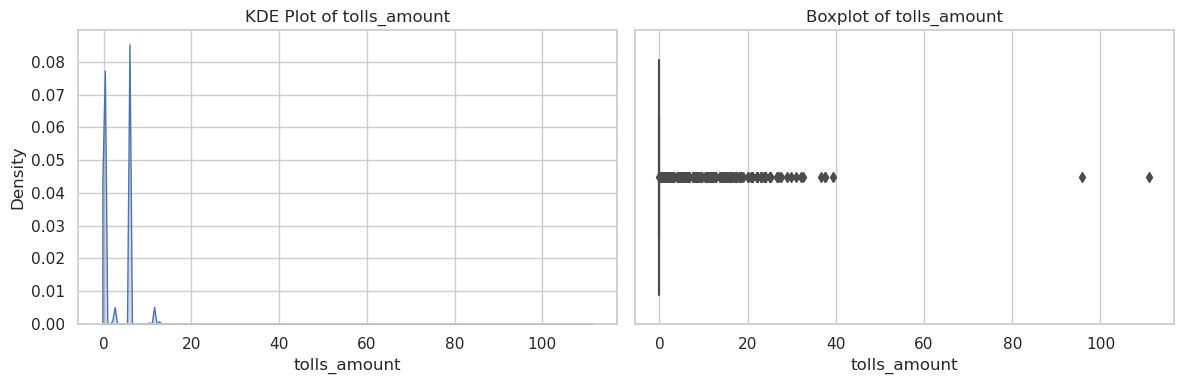

Exploring feature: improvement_surcharge
Number of Null Values: 0
Number of Unique Values: 2
Statistics: count    643047.000000
mean          0.255048
std           0.107075
min           0.000000
25%           0.300000
50%           0.300000
75%           0.300000
max           0.300000
Name: improvement_surcharge, dtype: float64



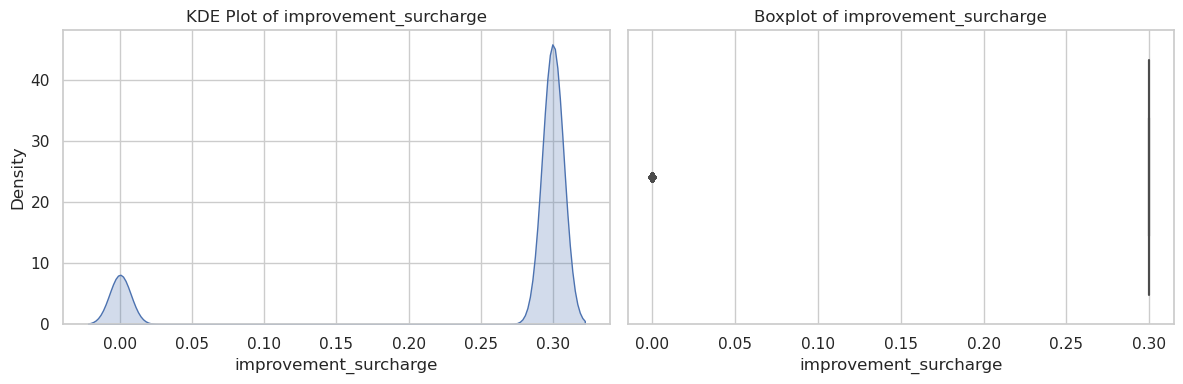

Exploring feature: total_amount
Number of Null Values: 0
Number of Unique Values: 7708
Statistics: count    643047.000000
mean         18.595585
std          15.570461
min           0.000000
25%           8.800000
50%          13.300000
75%          22.800000
max         944.980000
Name: total_amount, dtype: float64



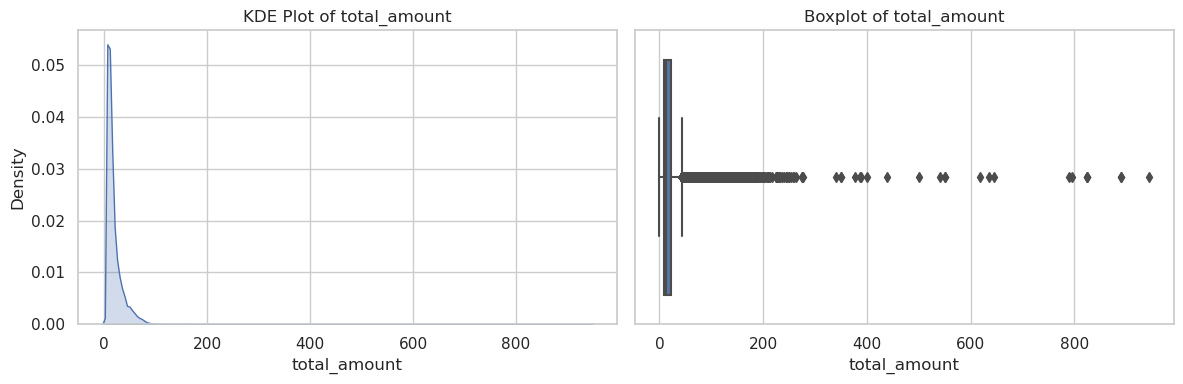

Exploring feature: congestion_surcharge
Number of Null Values: 0
Number of Unique Values: 4
Statistics: count    643047.000000
mean          0.500343
std           1.060860
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.750000
Name: congestion_surcharge, dtype: float64



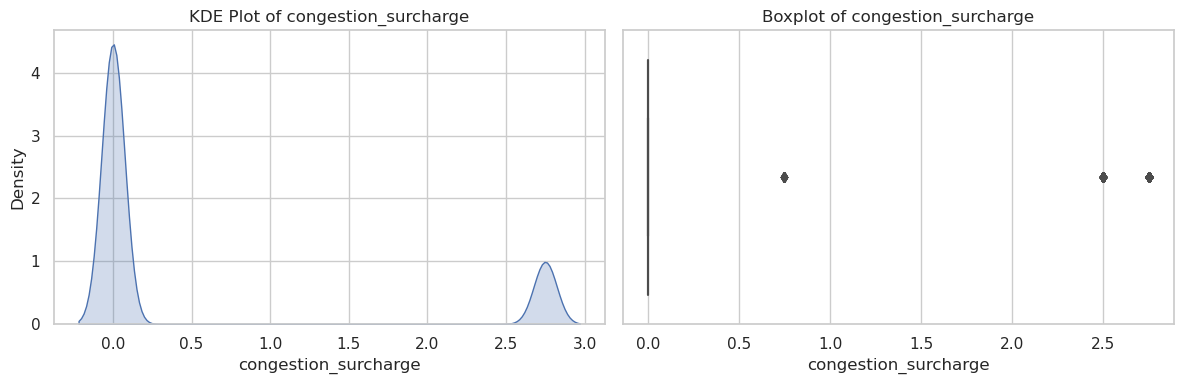

Exploring feature: rush_hour_overnight
Number of Null Values: 0
Number of Unique Values: 2
Statistics: count    643047.000000
mean          0.525130
std           0.499368
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rush_hour_overnight, dtype: float64



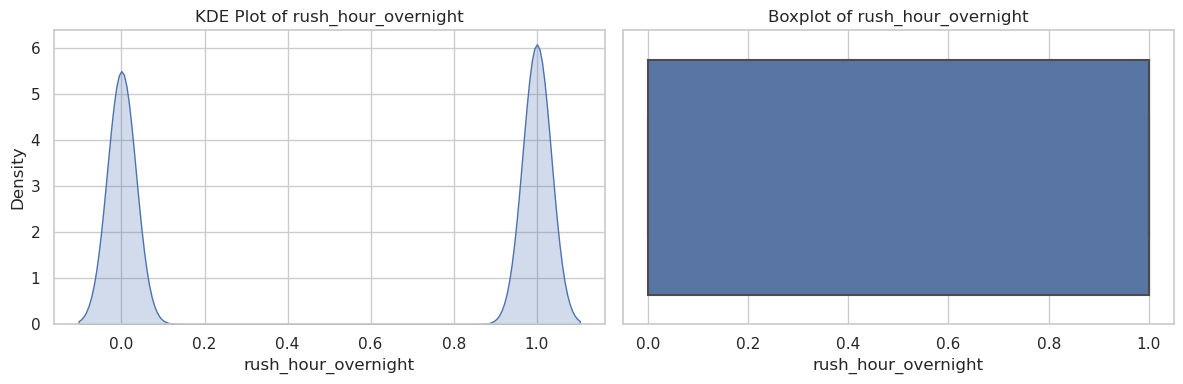

In [243]:
explore_numerical_features_after_clean(nyc_df_clean)

In [809]:
nyc_df_clean.shape

(643047, 25)

In [810]:
nyc_df_clean.columns

Index(['vendor', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'rate_type', 'pu_location', 'do_location',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'pickup_day',
       'pickup_hour', 'surcharge_introduced', 'rush_hour_overnight',
       'is_total_amount_valid', 'is_total_amount_valid_check'],
      dtype='object')

## Findings and conclusions

After observing and handling missing values :
- There are 3 new columns , all of them used to handle missing values for "extra" feature

## Observing outliers

In [811]:
nyc_df_clean.describe()

,lpep_pickup_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,pickup_hour,rush_hour_overnight
count,643047,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000
mean,2019-03-16 10:53:27.160389120,1.303882,3.852445,15.903488,0.315478,0.490621,0.855472,0.319188,0.255048,18.595585,0.500343,3.172673,13.688202,0.525130
min,2009-01-01 00:03:39,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-03-08 17:30:25.500000,1.000000,1.110000,7.000000,0.000000,0.500000,0.000000,0.000000,0.300000,8.800000,0.000000,2.000000,10.000000,0.000000
50%,2019-03-16 10:05:04,1.000000,2.180000,11.000000,0.000000,0.500000,0.000000,0.000000,0.300000,13.300000,0.000000,3.000000,14.000000,1.000000
75%,2019-03-23 23:20:02.500000,1.000000,4.770000,19.500000,0.500000,0.500000,1.360000,0.000000,0.300000,22.800000,0.000000,5.000000,18.000000,1.000000
max,2019-06-15 04:53:04,9.000000,603.800000,944.980000,10.400000,3.550000,222.220000,111.110000,0.300000,944.980000,2.750000,6.000000,23.000000,1.000000
std,NaN,0.924073,4.486270,14.415826,0.464512,0.068207,1.807673,1.404061,0.107075,15.570461,1.060860,1.934906,5.672495,0.499368


In [813]:
# Select numerical columns
numerical_cols = nyc_df_clean.select_dtypes(include=['float64']).columns

# Calculate and print skewness for each numerical column
for col in numerical_cols:
    skewness = skew(nyc_df_clean[col].dropna())
    print(f"Feature: {col}, Skewness: {skewness}")


Feature: passenger_count, Skewness: 3.759985790346894
Feature: trip_distance, Skewness: 6.052412345759369
Feature: fare_amount, Skewness: 5.309405184963231
Feature: extra, Skewness: 2.63216507980029
Feature: mta_tax, Skewness: -6.568566207312864
Feature: tip_amount, Skewness: 9.863771694958443
Feature: tolls_amount, Skewness: 6.153920550334084
Feature: improvement_surcharge, Skewness: -1.9621361677954778
Feature: total_amount, Skewness: 4.618065615963907
Feature: congestion_surcharge, Skewness: 1.6487145548011097


In [814]:
# copy the dataframe to a new one for handling outliers
nyc_df_handled_outliers = nyc_df_clean.copy()

In [815]:
def detect_outlier_Zscore(featureName , dataframe , threshold = 3 ):
    
    # get the current Column
    feature = dataframe[featureName]
    
    # calculate the z score
    z = np.abs(stats.zscore(feature))
    
    # mean & std
    mean = np.mean(feature)
    std = np.std(feature)
    
    
    upper_limit = mean + threshold * std
    lower_limit = mean - threshold * std
    print(f"The upper limit is {upper_limit}")
    print(f"The lower limit is {lower_limit}")
    
    
    # return the number of outliers where Any value that has 
    # a std greater than threshold or less than -threshold std will be considered as an outlier , lower_limit and upper_limit
    return dataframe[(z > threshold) | (z < -threshold)].shape[0] , lower_limit , upper_limit

In [816]:
# get numrical features name
numricalFeatures = nyc_df_clean.select_dtypes(include = ['int64','float']).columns.tolist()

# limits to save upper_limit and lower_limit for each category instead of calling the method twice for each feature
limits = {}

for feature in numricalFeatures:
    
    print(feature)
    
    # save values coming from z-score
    limits[feature] = detect_outlier_Zscore(feature , nyc_df_clean , 3.5)
    
    print(f"Number of Outliers (ZScore) in {feature} : {limits[feature][0]} ")
    print("-----------------------------------------------------------------\n")

passenger_count
The upper limit is 4.5381352602881515
The lower limit is -1.9303709006609522
Number of Outliers (ZScore) in passenger_count : 26443 
-----------------------------------------------------------------

trip_distance
The upper limit is 19.55437808737897
The lower limit is -11.8494890512743
Number of Outliers (ZScore) in trip_distance : 9026 
-----------------------------------------------------------------

fare_amount
The upper limit is 66.35884153043918
The lower limit is -34.55186536851009
Number of Outliers (ZScore) in fare_amount : 6826 
-----------------------------------------------------------------

extra
The upper limit is 1.9412683410699443
The lower limit is -1.3103125944448917
Number of Outliers (ZScore) in extra : 5750 
-----------------------------------------------------------------

mta_tax
The upper limit is 0.7293454707563172
The lower limit is 0.25189586930125246
Number of Outliers (ZScore) in mta_tax : 12084 
-------------------------------------------

## Handling outliers

In [817]:
def handle_outliers(dataFrame):
    
    
    # Create a copy of the database to store the changes on it
    nyc_handle_outliers = dataFrame.copy()
        
    
    # get numrical features name
    numricalFeatures = nyc_handle_outliers.select_dtypes(include = ['int64','float']).columns.tolist()
    
    for feature in numricalFeatures:
        
        lower_limit , upper_limit = limits[feature][1:]
        
        filtered_data = nyc_handle_outliers[nyc_handle_outliers[feature].between(lower_limit, upper_limit, inclusive='neither')]
        median = math.ceil(filtered_data[feature].median())
        
        # replace outliers by the median
        nyc_handle_outliers[feature] = np.where(nyc_handle_outliers[feature] < lower_limit , median  , nyc_handle_outliers[feature])
        nyc_handle_outliers[feature] = np.where(nyc_handle_outliers[feature] > upper_limit , median  , nyc_handle_outliers[feature])
        
    return nyc_handle_outliers

In [648]:
# Get the new handled data
nyc_df_handled_outliers = handle_outliers(nyc_df_handled_outliers)

In [649]:
# check after handling outliers
nyc_df_handled_outliers.describe()

,lpep_pickup_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,pickup_hour,rush_hour_overnight
count,643047,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000,643047.000000
mean,2019-03-16 10:53:27.160389120,1.125499,3.565534,15.181278,0.289912,0.509396,0.744039,0.013252,0.255048,17.822263,0.500343,3.172673,13.688202,0.525130
min,2009-01-01 00:03:39,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-03-08 17:30:25.500000,1.000000,1.110000,7.000000,0.000000,0.500000,0.000000,0.000000,0.300000,8.800000,0.000000,2.000000,10.000000,0.000000
50%,2019-03-16 10:05:04,1.000000,2.180000,11.000000,0.000000,0.500000,0.000000,0.000000,0.300000,13.300000,0.000000,3.000000,14.000000,1.000000
75%,2019-03-23 23:20:02.500000,1.000000,4.520000,19.000000,0.500000,0.500000,1.260000,0.000000,0.300000,21.960000,0.000000,5.000000,18.000000,1.000000
max,2019-06-15 04:53:04,4.000000,19.550000,66.340000,1.900000,1.000000,7.180000,5.160000,0.300000,73.070000,2.750000,6.000000,23.000000,1.000000
std,NaN,0.383745,3.727959,12.298297,0.388974,0.067895,1.354142,0.183211,0.107075,13.361056,1.060860,1.934906,5.672495,0.499368


In [650]:
# Double-check after handling outliers by checking skewness values

numerical_cols = nyc_df_handled_outliers.select_dtypes(include=['float64']).columns

# Calculate and print skewness for each numerical column
for col in numerical_cols:
    skewness = skew(nyc_df_handled_outliers[col].dropna())
    print(f"Feature: {col}, Skewness: {skewness}")

Feature: passenger_count, Skewness: 4.120873742207792
Feature: trip_distance, Skewness: 1.9365100691246238
Feature: fare_amount, Skewness: 1.7520126945048922
Feature: extra, Skewness: 1.0380526022740044
Feature: mta_tax, Skewness: 7.087587632633938
Feature: tip_amount, Skewness: 2.011992988803847
Feature: tolls_amount, Skewness: 14.249025525925287
Feature: improvement_surcharge, Skewness: -1.9621361677954778
Feature: total_amount, Skewness: 1.7062623932941654
Feature: congestion_surcharge, Skewness: 1.6487145548011097


Exploring feature: passenger_count
Number of Null Values: 0
Number of Unique Values: 5
Statistics: count    643047.000000
mean          1.125499
std           0.383745
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: passenger_count, dtype: float64



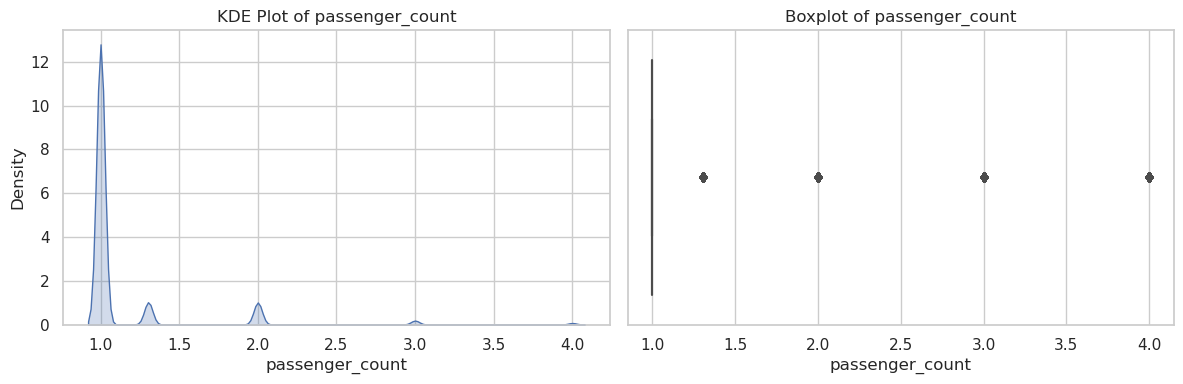

Exploring feature: trip_distance
Number of Null Values: 0
Number of Unique Values: 1956
Statistics: count    643047.000000
mean          3.565534
std           3.727959
min           0.000000
25%           1.110000
50%           2.180000
75%           4.520000
max          19.550000
Name: trip_distance, dtype: float64



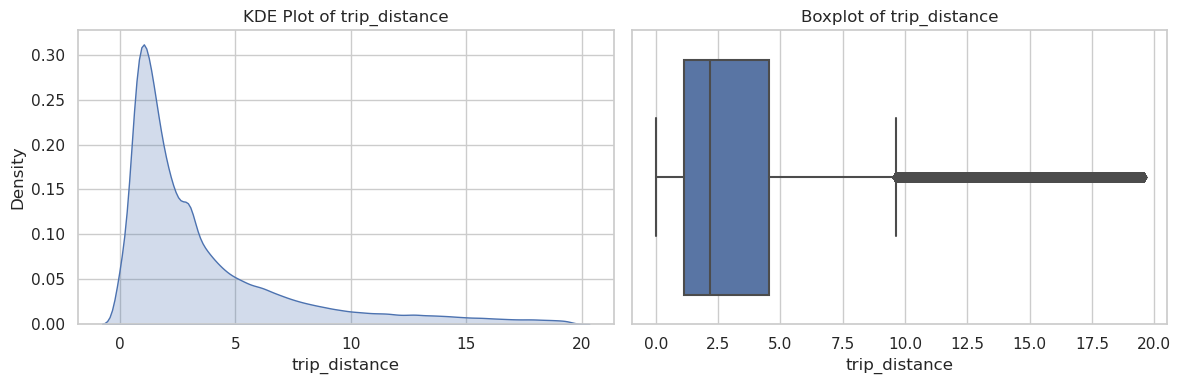

Exploring feature: fare_amount
Number of Null Values: 0
Number of Unique Values: 5013
Statistics: count    643047.000000
mean         15.181278
std          12.298297
min           0.000000
25%           7.000000
50%          11.000000
75%          19.000000
max          66.340000
Name: fare_amount, dtype: float64



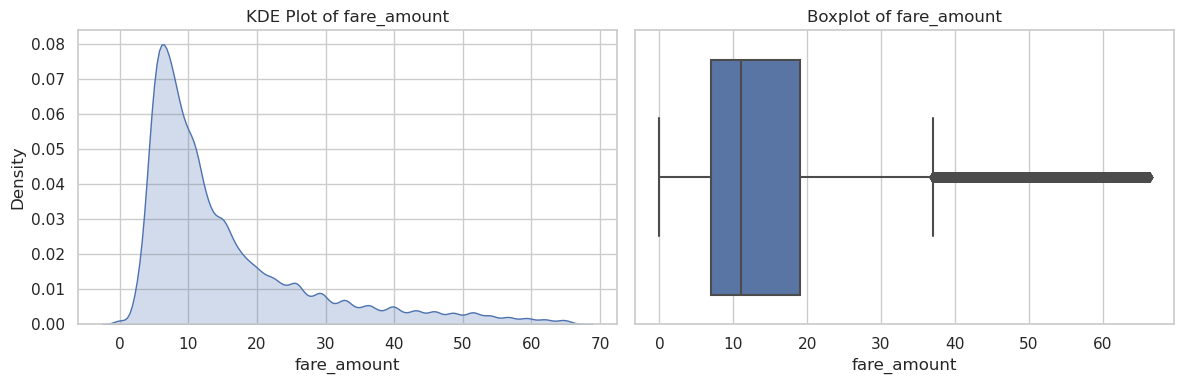

Exploring feature: extra
Number of Null Values: 0
Number of Unique Values: 5
Statistics: count    643047.000000
mean          0.289912
std           0.388974
min           0.000000
25%           0.000000
50%           0.000000
75%           0.500000
max           1.900000
Name: extra, dtype: float64



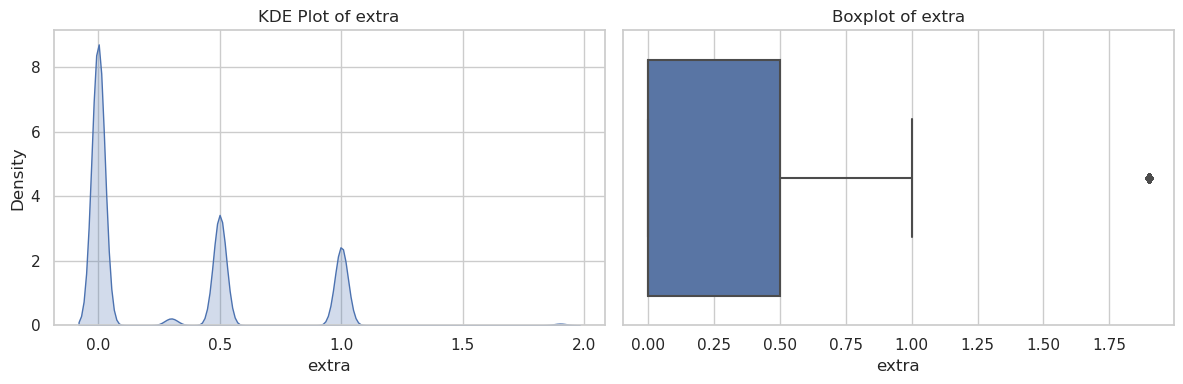

Exploring feature: mta_tax
Number of Null Values: 0
Number of Unique Values: 2
Statistics: count    643047.000000
mean          0.509396
std           0.067895
min           0.500000
25%           0.500000
50%           0.500000
75%           0.500000
max           1.000000
Name: mta_tax, dtype: float64



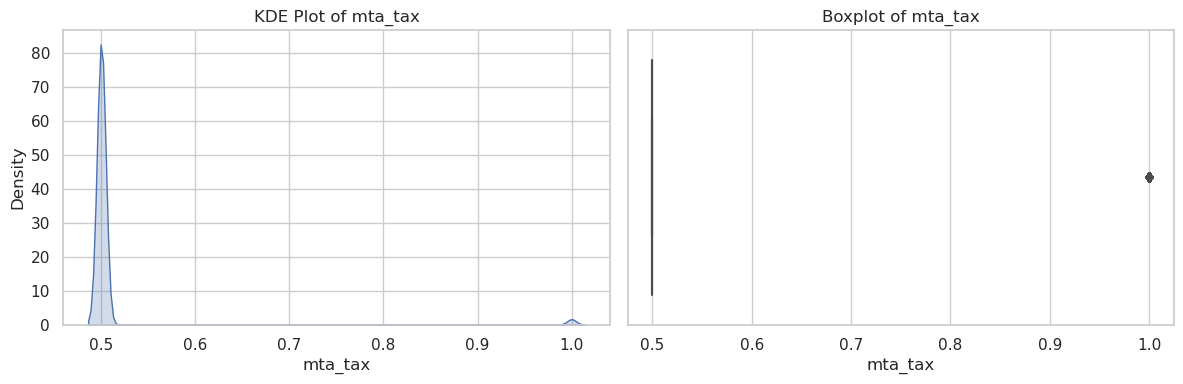

Exploring feature: tip_amount
Number of Null Values: 0
Number of Unique Values: 683
Statistics: count    643047.000000
mean          0.744039
std           1.354142
min           0.000000
25%           0.000000
50%           0.000000
75%           1.260000
max           7.180000
Name: tip_amount, dtype: float64



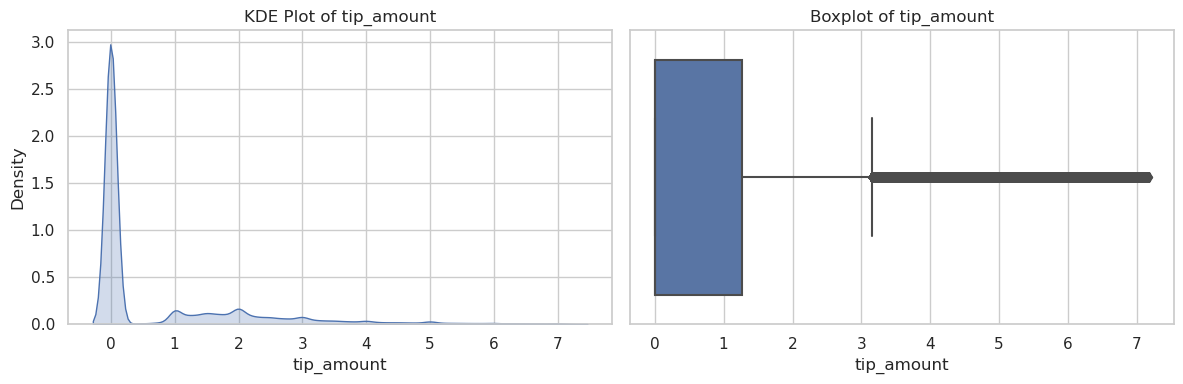

Exploring feature: tolls_amount
Number of Null Values: 0
Number of Unique Values: 30
Statistics: count    643047.000000
mean          0.013252
std           0.183211
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.160000
Name: tolls_amount, dtype: float64



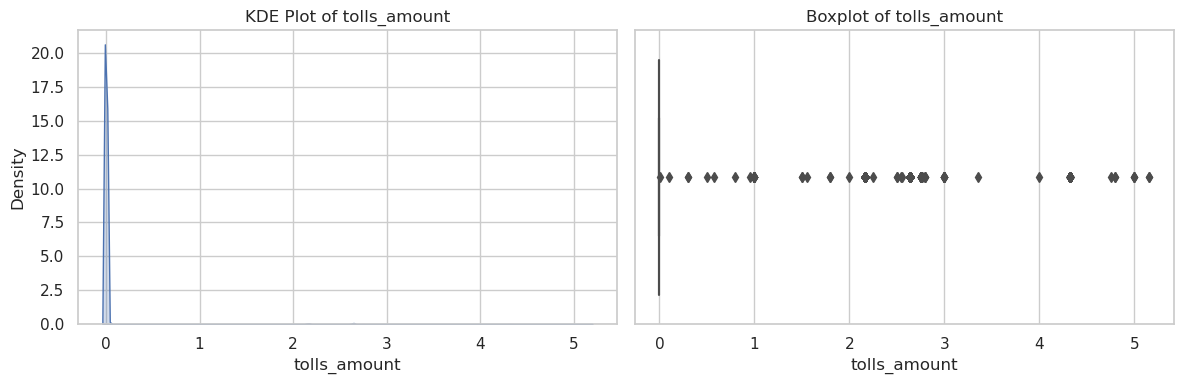

Exploring feature: improvement_surcharge
Number of Null Values: 0
Number of Unique Values: 2
Statistics: count    643047.000000
mean          0.255048
std           0.107075
min           0.000000
25%           0.300000
50%           0.300000
75%           0.300000
max           0.300000
Name: improvement_surcharge, dtype: float64



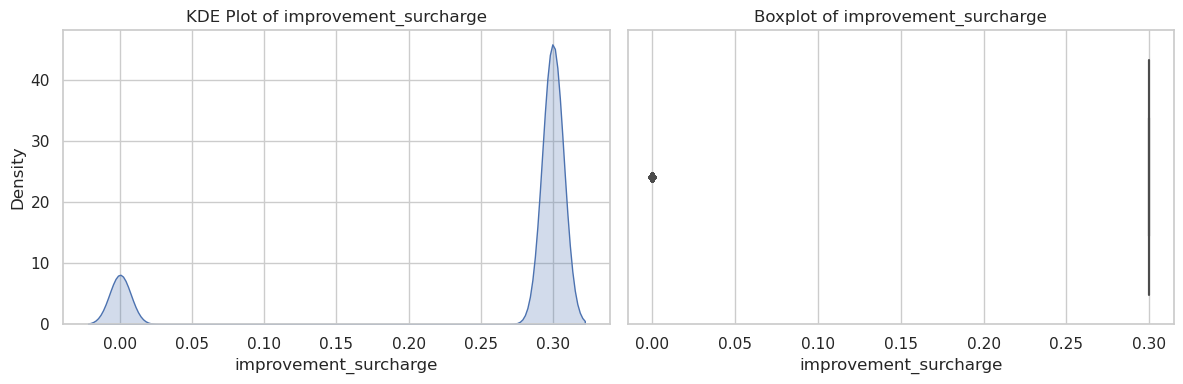

Exploring feature: total_amount
Number of Null Values: 0
Number of Unique Values: 6382
Statistics: count    643047.000000
mean         17.822263
std          13.361056
min           0.000000
25%           8.800000
50%          13.300000
75%          21.960000
max          73.070000
Name: total_amount, dtype: float64



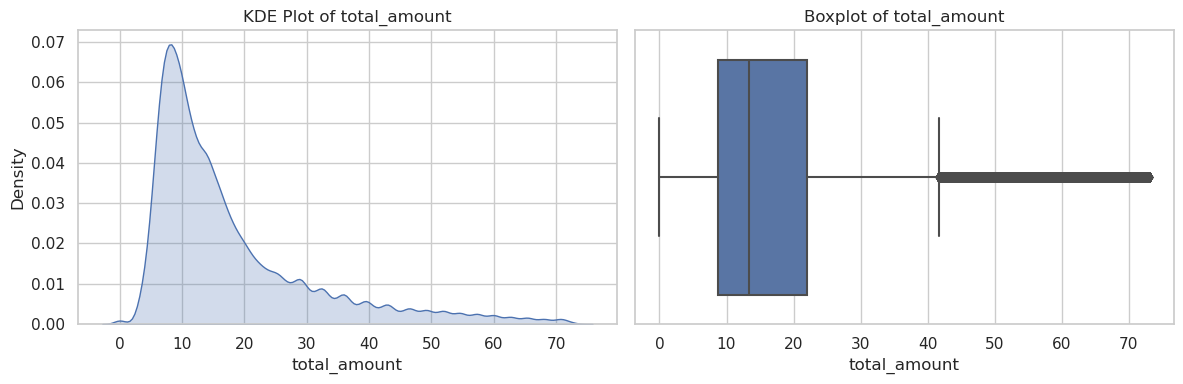

Exploring feature: congestion_surcharge
Number of Null Values: 0
Number of Unique Values: 4
Statistics: count    643047.000000
mean          0.500343
std           1.060860
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.750000
Name: congestion_surcharge, dtype: float64



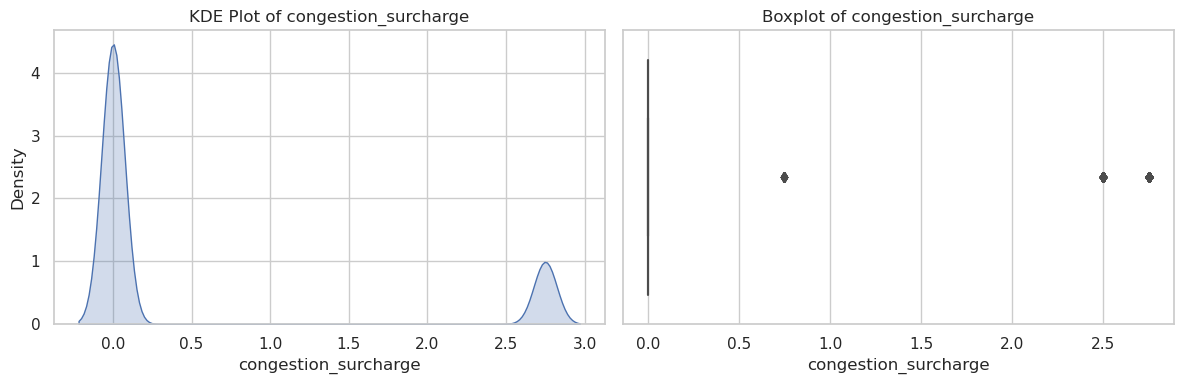

Exploring feature: rush_hour_overnight
Number of Null Values: 0
Number of Unique Values: 2
Statistics: count    643047.000000
mean          0.525130
std           0.499368
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rush_hour_overnight, dtype: float64



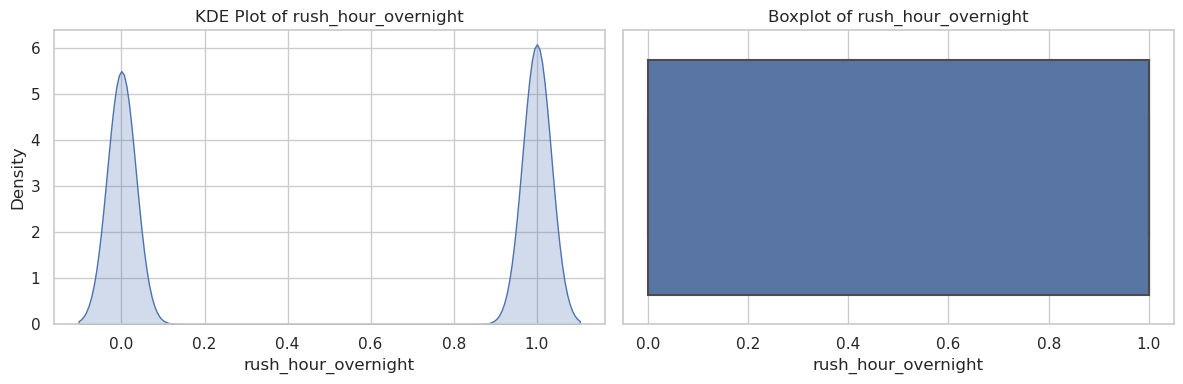

In [253]:
explore_numerical_features_after_clean(nyc_df_handled_outliers)

## Findings and conclusions

Z-score analysis was conducted on various features in the dataset, aiming to identify outliers. Outliers were determined by measuring how many standard deviations a data point deviates from the mean. The analysis revealed the following key points:
   
- Passenger Count: There are 26,443 outliers, indicating unusual numbers of passengers in certain trips.
- Trip Distance: 9,026 outliers exist, suggesting extremely short or long trip distances.
- Fare Amount:  6,826 outliers were found, possibly due to incorrect fare calculations or specific fare rules.
- Extra Charge: 5,750 outliers indicate special circumstances where additional charges were applied.
- MTA Tax: 12,084 outliers may indicate irregularities in tax calculations during trips.
- Tip Amount: 6,821 outliers represent unusually large or small tips given by passengers.
- Tolls Amount: 32,129 outliers suggest significantly higher or lower toll charges in specific trips.
- Improvement Surcharge: No outliers were found; all values fall within the acceptable range.
- Total Amount: 6,869 outliers might be due to incorrect fare calculation or additional charges.
- Congestion Surcharge: No outliers were detected; all values fall within the acceptable range.
- Rush Hour Overnight Charge: No outliers were observed; all values fall within the acceptable range.

After handling the outliers , some features tend to have a normal distributions more than before   

# 4 - Data transformation and feature eng.

## 4.1 - Discretization

In [818]:
nyc_df_handled_outliers['lpep_pickup_datetime'] = pd.to_datetime(nyc_df_handled_outliers['lpep_pickup_datetime'])
nyc_df_handled_outliers['lpep_dropoff_datetime'] = pd.to_datetime(nyc_df_handled_outliers['lpep_dropoff_datetime'])

In [819]:
nyc_df_handled_outliers['week_number'] = nyc_df_handled_outliers['lpep_pickup_datetime'].dt.isocalendar().week

In [820]:
nyc_df_handled_outliers['date_range'] = nyc_df_handled_outliers['lpep_pickup_datetime'].dt.strftime('%Y-%m-%d') + ' - ' + nyc_df_handled_outliers['lpep_dropoff_datetime'].dt.strftime('%Y-%m-%d')

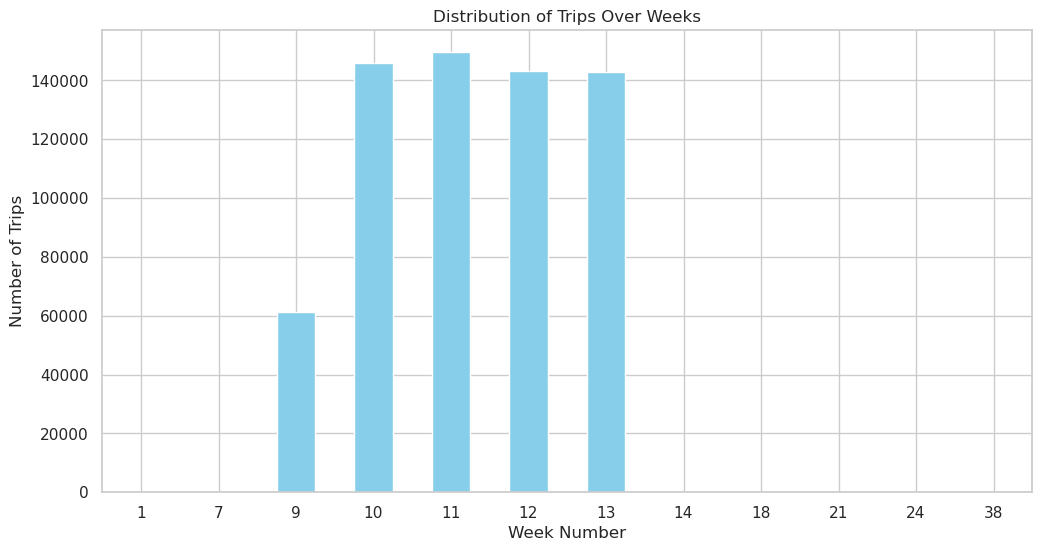

In [821]:
# Count the occurrences of each week number
week_counts = nyc_df_handled_outliers['week_number'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
week_counts.sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Week Number')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips Over Weeks')
plt.xticks(rotation=0)
plt.show()

## 4.11 - Findings and conclusions

It seems that Numner of trips in week 9 are less than the other weeks 

It may go back that week 9 was mid-year break , so people are not want to go out mostly

In [822]:
explore_categorical_features(nyc_df_handled_outliers)

Column: vendor
Number of Null Values: 0
Number of Unique Values: 3
Value Counts:
vendor
VeriFone Inc.                        553548
Creative Mobile Technologies, LLC     89498
Unknown                                   1
Name: count, dtype: int64
Column: store_and_fwd_flag
Number of Null Values: 0
Number of Unique Values: 2
Value Counts:
store_and_fwd_flag
N    641938
Y      1109
Name: count, dtype: int64
Column: rate_type
Number of Null Values: 0
Number of Unique Values: 7
Value Counts:
rate_type
Standard rate            544874
Negotiated fare           53972
Unknown                   42565
JFK                         987
Nassau or Westchester       407
Newark                      233
Group ride                    9
Name: count, dtype: int64
Column: pu_location
Number of Null Values: 0
Number of Unique Values: 233
Value Counts:
pu_location
Manhattan,East Harlem North                                42524
Manhattan,East Harlem South                                35713
Manhattan,Central 

## 4.2 - Encoding

In [823]:
nyc_df_to_encode=nyc_df_handled_outliers.copy()
nyc_df_to_encode

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,trip_type,congestion_surcharge,pickup_day,pickup_hour,surcharge_introduced,rush_hour_overnight,is_total_amount_valid,is_total_amount_valid_check,week_number,date_range
0,VeriFone Inc.,2019-03-01 00:02:21,2019-03-01 00:04:52,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,3.5,...,Street-hail,0.0,4,0,True,1,False,True,9,2019-03-01 - 2019-03-01
1,VeriFone Inc.,2019-03-01 00:42:31,2019-03-01 00:47:42,N,Standard rate,"Brooklyn,East Williamsburg","Brooklyn,Williamsburg (South Side)",1.0,0.72,5.5,...,Street-hail,0.0,4,0,True,1,True,True,9,2019-03-01 - 2019-03-01
2,"Creative Mobile Technologies, LLC",2019-03-01 00:15:53,2019-03-01 00:18:37,N,Standard rate,"Queens,Astoria","Queens,Old Astoria",1.0,0.50,4.0,...,Street-hail,0.0,4,0,True,1,True,True,9,2019-03-01 - 2019-03-01
3,VeriFone Inc.,2019-02-28 23:55:58,2019-03-01 00:01:30,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.19,6.0,...,Street-hail,0.0,3,23,True,1,False,True,9,2019-02-28 - 2019-03-01
4,VeriFone Inc.,2019-03-01 00:55:58,2019-03-01 00:58:12,N,Standard rate,"Queens,Steinway","Queens,Steinway",1.0,0.55,4.0,...,Street-hail,0.0,4,0,True,1,True,True,9,2019-03-01 - 2019-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643065,VeriFone Inc.,2019-04-01 00:31:24,2019-04-01 00:38:28,N,Standard rate,"Queens,Elmhurst","Queens,Elmhurst",1.0,1.57,7.0,...,Street-hail,0.0,0,0,True,1,True,True,14,2019-04-01 - 2019-04-01
643066,VeriFone Inc.,2019-04-01 00:48:30,2019-04-01 00:58:28,N,Standard rate,"Queens,Elmhurst","Queens,Elmhurst/Maspeth",1.0,0.88,8.0,...,Street-hail,0.0,0,0,True,1,True,True,14,2019-04-01 - 2019-04-01
643067,"Creative Mobile Technologies, LLC",2019-04-01 00:04:42,2019-04-01 00:16:50,N,Standard rate,"Queens,Astoria","Queens,Jackson Heights",1.0,3.10,12.0,...,Street-hail,0.0,0,0,True,1,True,True,14,2019-04-01 - 2019-04-01
643068,"Creative Mobile Technologies, LLC",2019-04-01 00:01:51,2019-04-01 00:10:34,N,Standard rate,"Queens,Old Astoria","Queens,Jackson Heights",1.0,2.80,10.5,...,Street-hail,0.0,0,0,True,1,True,True,14,2019-04-01 - 2019-04-01


In [824]:
# Update the lookup table
def update_lookup( lookup , dictionary , column_name ):
    
    # create dataframe
    feature_lookup_table = pd.DataFrame()
    
    feature_lookup_table['Value'] = dictionary.keys()
    feature_lookup_table['Imputed_value'] = dictionary.values()
    feature_lookup_table['Column'] = [column_name] * len(dictionary)

    #concatination the two lookups dataframes
    lookup = pd.concat([lookup,feature_lookup_table],axis = 0)
    
    return lookup


In [825]:
def get_coded_dict_labeled(df,column_name):
    """
    Perform label encoding on a specified column in the DataFrame and create a dictionary mapping
    encoded values to their original representations.
    
    Args:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column to be label encoded.
    
    Returns:
    - dict: Dictionary mapping encoded values to their original representations.
    """
    tmp_df=df.copy()
    # Create a LabelEncoder object

    le = LabelEncoder()
    # Encode the 'category' column

    tmp_df[column_name] = le.fit_transform(tmp_df[column_name])
    # Create a dict that maps the encoded values to their real values

    category_to_real_value = {name: label for name, label in zip(le.classes_, le.transform(le.classes_))}
   
    # Create a dictionary mapping label encoded values to original values
   
    #encoded_to_original_dict = {encoded: original for encoded, original in zip(nyc_df_encoded[column_name], unique_values)}
    
    return category_to_real_value

# Example usage:
# encoded_dict = get_coded_dict(nyc_df_clean, "your_column_name")
# print("Encoded to Original Mapping:", encoded_dict)


In [826]:
def get_coded_dict_one_hot(df, column_name):
    """
    Perform one-hot encoding on a specified column in the DataFrame and create a dictionary mapping
    encoded values to their original representations.
    
    Args:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column to be one-hot encoded.
    
    Returns:
    - dict: Dictionary mapping encoded values to their original representations.
    """
    
    tmp_df = df.copy()
    
    # Create a OneHotEncoder object
    enc = OneHotEncoder(sparse=False)

    # Encode the specified column
    encoded_values = enc.fit_transform(tmp_df[column_name].values.reshape(-1, 1))
    
    # Get feature names after one-hot encoding
    feature_names = enc.get_feature_names_out([column_name])
    
    # Create a DataFrame with one-hot encoded values
    encoded_df = pd.DataFrame(encoded_values, columns=feature_names)

    # Add the one-hot encoded columns to the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)

    # Create a dict that maps the encoded values to their real values
    category_to_real_value = {name: label for name, label in zip(encoded_df.columns, enc.categories_[0])}

    return category_to_real_value

# Example usage:
# encoded_dict = get_coded_dict_one_hot(nyc_df_clean, "your_column_name")
# print("Encoded to Original Mapping:", encoded_dict)


In [827]:
def get_imputed_dict_missing(df, column_name, imputed_value):
    """
    Create a dictionary mapping imputed values to their corresponding real missing values in a specific column.
    
    Args:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column with missing values.
    - imputed_value: The imputed value used to fill missing values in the specified column.
    
    Returns:
    - dict: Dictionary mapping imputed values to their corresponding real missing values.
    """
    tmp_df = nyc_df_clean.copy()
    
    # Filter rows where the original value is nan, None, or missing
    filtered_df = df[df[column_name].isnull() | (df[column_name] == 'missing_value')]
    
    # Create a dictionary mapping imputed values to real missing values
    #imputed_to_missing_dict = {imputed_value: missing_value for imputed_value, missing_value in zip(filtered_df[column_name], tmp_df[column_name].fillna(imputed_value))}
    imputed_to_missing_dict = {}
    for imputed_value, missing_value in zip(filtered_df[column_name], tmp_df[column_name].fillna(imputed_value)):
        imputed_to_missing_dict[imputed_value] = missing_value
        break
    return imputed_to_missing_dict


In [828]:
def one_hot_encode(df, columns_to_encode, exclude_values=None):
    """
    Perform One-Hot Encoding on specified columns in the DataFrame and exclude specific values.
    
    Args:
    - df (pd.DataFrame): Input DataFrame.
    - columns_to_encode (list): List of column names to be one-hot encoded.
    - exclude_values (dict): Dictionary containing column names as keys and list of values to exclude as values.
    
    Returns:
    - pd.DataFrame: DataFrame with one-hot encoding applied to the specified columns.
    """
    # Ensure all columns exist in the DataFrame
    missing_columns = [col for col in columns_to_encode if col not in df.columns]
    if missing_columns:
        print(f"Error: Columns {missing_columns} not found in the DataFrame.")
        return df
    
    # Filter DataFrame to exclude specific values
    if exclude_values:
        for column, values_to_exclude in exclude_values.items():
            df = df[~df[column].isin(values_to_exclude)]
    
    # Apply One-Hot Encoding for each specified column
    encoded_df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode, drop_first=False)
    return encoded_df

In [829]:
def label_encode(df, columns_to_encode):
    """
    Perform Label Encoding on specified columns in the DataFrame.
    
    Args:
    - df (pd.DataFrame): Input DataFrame.
    - columns_to_encode (list): List of column names to be label encoded.
    
    Returns:
    - pd.DataFrame: DataFrame with label encoding applied to the specified columns.
    """
    # Ensure all columns exist in the DataFrame
    missing_columns = [col for col in columns_to_encode if col not in df.columns]
    if missing_columns:
        print(f"Error: Columns {missing_columns} not found in the DataFrame.")
        return df
    
    # Apply Label Encoding for each specified column
    encoder = LabelEncoder()
    for column in columns_to_encode:
        df[column] = encoder.fit_transform(df[column])
        
    return df

In [830]:
def frequency_encode(df, columns_to_encode):
    """
    Perform Frequency Encoding on specified columns in the DataFrame.
    
    Args:
    - df (pd.DataFrame): Input DataFrame.
    - columns_to_encode (list): List of column names to be frequency encoded.
    
    Returns:
    - pd.DataFrame: DataFrame with frequency encoding applied to the specified columns.
    """
    for column_name in columns_to_encode:
        frequency_map = df[column_name].value_counts(normalize=True)
        df[column_name] = df[column_name].map(frequency_map)
        
    return df

In [831]:
# Perform One-Hot encoding
exclude_values = {'vendor': ['Unknown'],'rate_type':['Group ride'],'payment_type': []}
nyc_df_encoded = one_hot_encode(nyc_df_to_encode, columns_to_encode=['vendor','rate_type','payment_type'], exclude_values=exclude_values)

In [832]:
# Perform Label encoding
nyc_df_encoded=label_encode(nyc_df_encoded,['store_and_fwd_flag','trip_type','date_range'])

In [833]:
# Perform Frequency encoding
nyc_df_encoded=frequency_encode(nyc_df_encoded,['pu_location','do_location'])

In [834]:
# init the lookup table
lookup = pd.DataFrame(columns=['Column','Value','Imputed_value'])

# loop over the features to get the dict for the lookup table
one_hot_encoded_features=['vendor','rate_type','payment_type']
for col in one_hot_encoded_features:
    encoded_dict_one = get_coded_dict_one_hot(nyc_df_handled_outliers, col)
    lookup = update_lookup(lookup,encoded_dict_one,col)

In [835]:
# Do the same thing with the features encoded with label encoding

# loop over the features to get the dict for the lookup table
label_encoded_features=['store_and_fwd_flag','trip_type','date_range']

for col in label_encoded_features:
    encoded_dict_label = get_coded_dict_labeled(nyc_df_handled_outliers, col)
    lookup = update_lookup(lookup,encoded_dict_label,col)

In [836]:
rename_columns(nyc_df_encoded)
nyc_df_encoded.columns

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag',
       'pu_location', 'do_location', 'passenger_count', 'trip_distance',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_type',
       'congestion_surcharge', 'pickup_day', 'pickup_hour',
       'surcharge_introduced', 'rush_hour_overnight', 'is_total_amount_valid',
       'is_total_amount_valid_check', 'week_number', 'date_range',
       'vendor_creative_mobile_technologies,_llc', 'vendor_verifone_inc.',
       'rate_type_jfk', 'rate_type_nassau_or_westchester',
       'rate_type_negotiated_fare', 'rate_type_newark',
       'rate_type_standard_rate', 'rate_type_unknown', 'payment_type_cash',
       'payment_type_credit_card', 'payment_type_dispute',
       'payment_type_no_charge', 'payment_type_unknown'],
      dtype='object')

In [837]:
# Rename the column 'vendor_verifone_inc.' as it may cause error when try to access it
nyc_df_encoded.rename(columns={'vendor_verifone_inc.': 'vendor_verifone_inc'}, inplace=True)
nyc_df_encoded.rename(columns={ 'vendor_creative_mobile_technologies,_llc':  'vendor_creative_mobile_technologies_llc'}, inplace=True)

In [838]:
# Verify all columns names
nyc_df_encoded.columns

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag',
       'pu_location', 'do_location', 'passenger_count', 'trip_distance',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_type',
       'congestion_surcharge', 'pickup_day', 'pickup_hour',
       'surcharge_introduced', 'rush_hour_overnight', 'is_total_amount_valid',
       'is_total_amount_valid_check', 'week_number', 'date_range',
       'vendor_creative_mobile_technologies_llc', 'vendor_verifone_inc',
       'rate_type_jfk', 'rate_type_nassau_or_westchester',
       'rate_type_negotiated_fare', 'rate_type_newark',
       'rate_type_standard_rate', 'rate_type_unknown', 'payment_type_cash',
       'payment_type_credit_card', 'payment_type_dispute',
       'payment_type_no_charge', 'payment_type_unknown'],
      dtype='object')

In [839]:
nyc_df_encoded

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,rate_type_nassau_or_westchester,rate_type_negotiated_fare,rate_type_newark,rate_type_standard_rate,rate_type_unknown,payment_type_cash,payment_type_credit_card,payment_type_dispute,payment_type_no_charge,payment_type_unknown
0,2019-03-01 00:02:21,2019-03-01 00:04:52,0,0.003683,0.005491,1.0,0.00,3.5,0.5,0.5,...,False,False,False,True,False,False,True,False,False,False
1,2019-03-01 00:42:31,2019-03-01 00:47:42,0,0.005001,0.005287,1.0,0.72,5.5,0.5,0.5,...,False,False,False,True,False,False,True,False,False,False
2,2019-03-01 00:15:53,2019-03-01 00:18:37,0,0.037553,0.009357,1.0,0.50,4.0,0.5,0.5,...,False,False,False,True,False,True,False,False,False,False
3,2019-02-28 23:55:58,2019-03-01 00:01:30,0,0.005656,0.004732,1.0,1.19,6.0,0.5,0.5,...,False,False,False,True,False,False,True,False,False,False
4,2019-03-01 00:55:58,2019-03-01 00:58:12,0,0.013921,0.015128,1.0,0.55,4.0,0.5,0.5,...,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643065,2019-04-01 00:31:24,2019-04-01 00:38:28,0,0.037581,0.015271,1.0,1.57,7.0,0.5,0.5,...,False,False,False,True,False,True,False,False,False,False
643066,2019-04-01 00:48:30,2019-04-01 00:58:28,0,0.037581,0.005737,1.0,0.88,8.0,0.5,0.5,...,False,False,False,True,False,True,False,False,False,False
643067,2019-04-01 00:04:42,2019-04-01 00:16:50,0,0.037553,0.023944,1.0,3.10,12.0,0.5,0.5,...,False,False,False,True,False,True,False,False,False,False
643068,2019-04-01 00:01:51,2019-04-01 00:10:34,0,0.005858,0.023944,1.0,2.80,10.5,0.5,0.5,...,False,False,False,True,False,False,True,False,False,False


## 4.22 - Findings and conlcusions

## 4.3 - Normalisation 

After looking visualization of featues after handling outliers , we found that Scalling may be applied to :
- trip_distance
- fare_amount
- total_amount

This scalling used to make all features contribute the same amount in prediction.

In [846]:
# Get features to be scaled
scaled_features=['trip_distance','fare_amount','total_amount']

In [841]:
def min_max_scaling(df, feature_names):
    """
    Perform Min-Max Scaling on specified numerical features in the DataFrame.
    
    Args:
    - df (pd.DataFrame): Input DataFrame.
    - feature_names (list): List of numerical feature names to be scaled.
    
    Returns:
    - pd.DataFrame: DataFrame with specified features scaled using Min-Max Scaling.
    """
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df[feature_names])
    df_scaled = pd.DataFrame(scaled_features, columns=feature_names, index=df.index)
    df[feature_names] = df_scaled
    return df

In [850]:
# Create a new dataframe for scalling
nyc_df_scaled=nyc_df_handled_outliers.copy()

In [851]:
# Scalling the dataframe 
nyc_df_scaled=min_max_scaling(nyc_df_scaled,scaled_features)

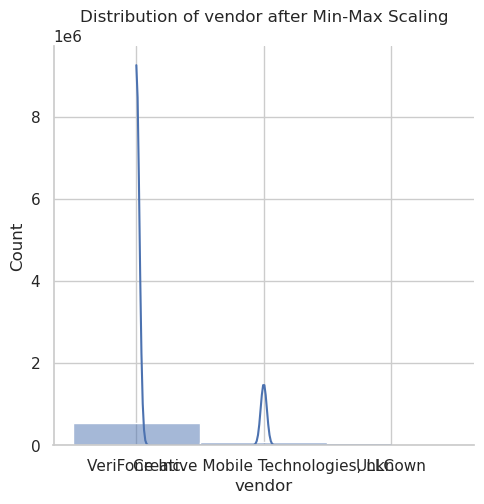

In [ ]:
for column in nyc_df_scaled.columns:
    sns.displot(nyc_df_scaled[column], kde=True)
    plt.title(f'Distribution of {column} after Min-Max Scaling')
    plt.show()

## 4.31 - Findings and conclusions

## 4.4 - Adding more features(feature eng.)

In [853]:
nyc_df_featured=nyc_df_handled_outliers.copy()

In [854]:
# Convert pickup datetime to datetime objects if not already in datetime format
nyc_df_featured['lpep_pickup_datetime'] = pd.to_datetime(nyc_df_featured['lpep_pickup_datetime'])

# Extract day of the week (0=Monday, 6=Sunday)
nyc_df_featured['pickup_day'] = nyc_df_featured['lpep_pickup_datetime'].dt.dayofweek

# Create 'IsWeekend' column (1 for weekend, 0 for weekdays)
nyc_df_featured['IsWeekend'] = nyc_df_featured['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)

# Drop 'pickup_day' column if not needed for further analysis
nyc_df_featured.drop(columns=['pickup_day'], inplace=True)


In [715]:
# Assuming 'fare_amount' is the column indicating the fare amount of the trip
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+']

nyc_df_featured['fare_category'] = pd.cut(nyc_df_featured['fare_amount'], bins=bins, labels=labels)


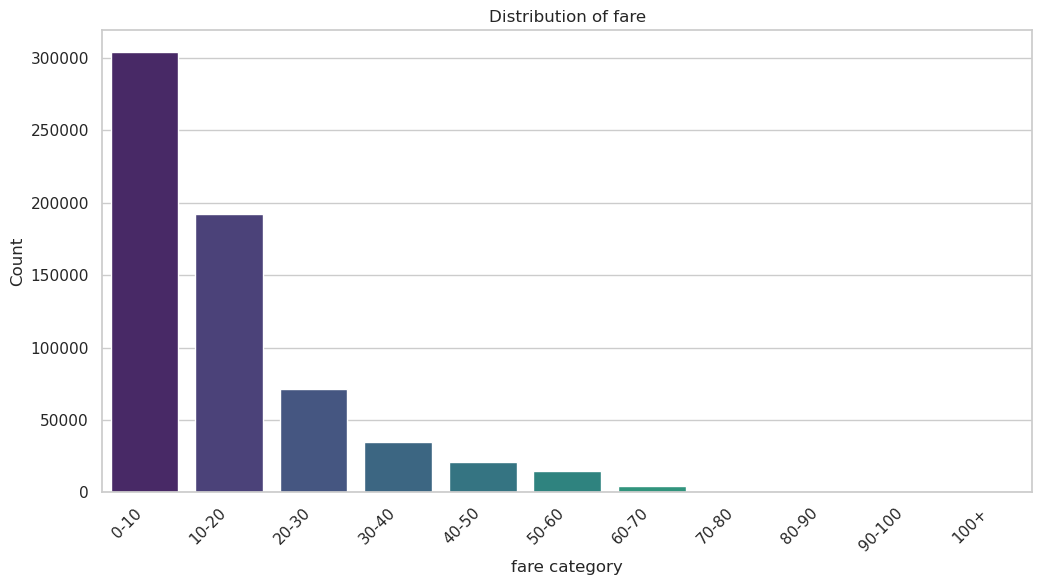

In [717]:
plt.figure(figsize=(12, 6))
sns.countplot(x='fare_category', data=nyc_df_featured, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('fare category')
plt.ylabel('Count')
plt.title('Distribution of fare')
plt.show()


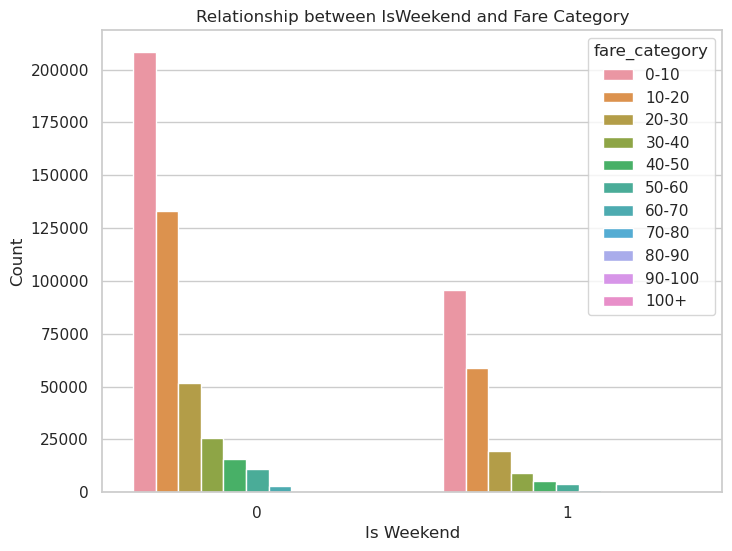

In [720]:
plt.figure(figsize=(8, 6))
sns.countplot(x='IsWeekend', hue='fare_category', data=nyc_df_featured)
plt.xlabel('Is Weekend')
plt.ylabel('Count')
plt.title('Relationship between IsWeekend and Fare Category')
plt.show()

## 4.41 - Findings and concluisons

## 4.5 - Additional data extraction (GPS coordinates)

## 4.6 - Csv file for lookup

Update the lookup table with columns that have missing values

In [741]:
# Get columns with null or NaN values
columns_with_null_values = nyc_df.columns[nyc_df.isnull().any()].tolist()
columns_with_null_values.remove("ehail_fee")
for col in columns_with_null_values:
    # Check if the column contains numerical or categorical data
    if pd.api.types.is_numeric_dtype(nyc_df[col]):
        if(col=="passenger_count"):
           replace_value= nyc_df_clean['passenger_count'].mean()
           dict=get_imputed_dict_missing(nyc_df, col, replace_value)
           lookup = update_lookup(lookup,dict,col)
        if(col=="congestion_surcharge"):
           replace_value= 2.75
           dict=get_imputed_dict_missing(nyc_df, col,replace_value)
           lookup = update_lookup(lookup,dict,col)
        else:
           dict=get_imputed_dict_missing(nyc_df, col,0)
           lookup = update_lookup(lookup,dict,col)
    else:
        replace_value =nyc_df[col].mode()[0]
        dict=get_imputed_dict_missing(nyc_df, col,replace_value)
        lookup = update_lookup(lookup,dict,col)

In [742]:
# Save lookup to csv
lookup.to_csv('lookup_table.csv')

## 5- Exporting the dataframe to a csv file or parquet

In [731]:
# Assuming nyc_df_handled_outliers is  cleaned DataFrame
nyc_df_handled_outliers.to_parquet('cleaned_data.parquet', index=False)

# This will save the DataFrame as a Parquet file without the index column.


In [ ]:
# How to Load the dataset from the parquet file

# new_df = pd.read_parquet('cleaned_data.parquet' )